# VarClump2D: Agglomeration test


In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# pycupid
from pycupid import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

## Loading `Orion KL`

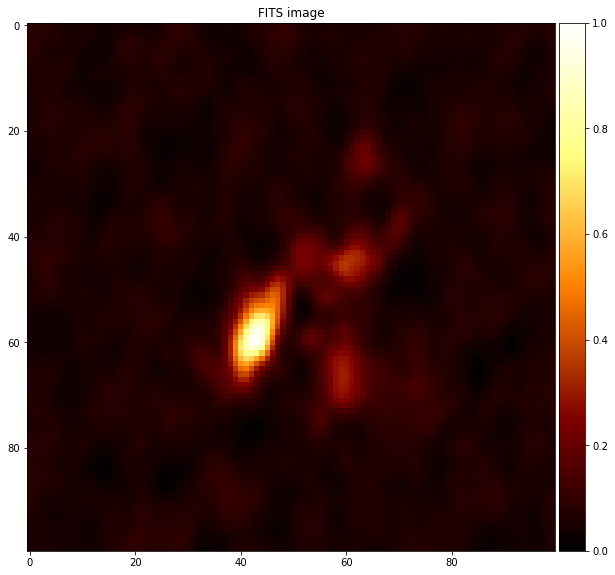

In [2]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

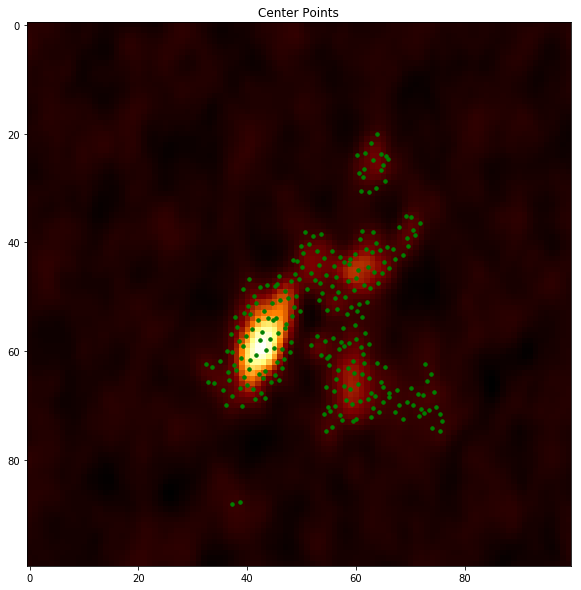

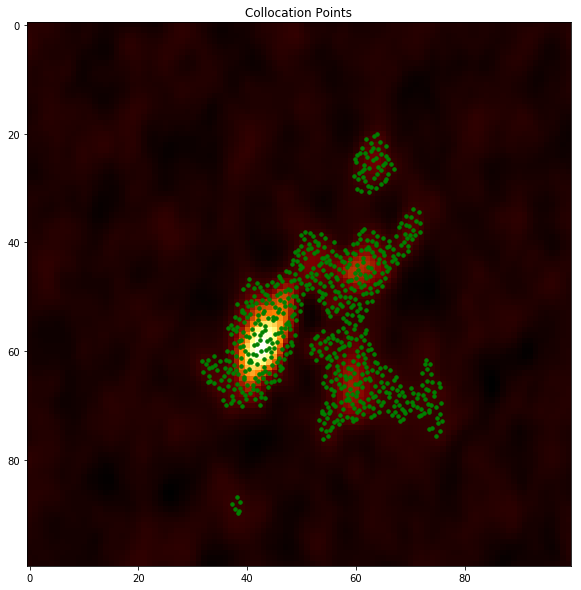

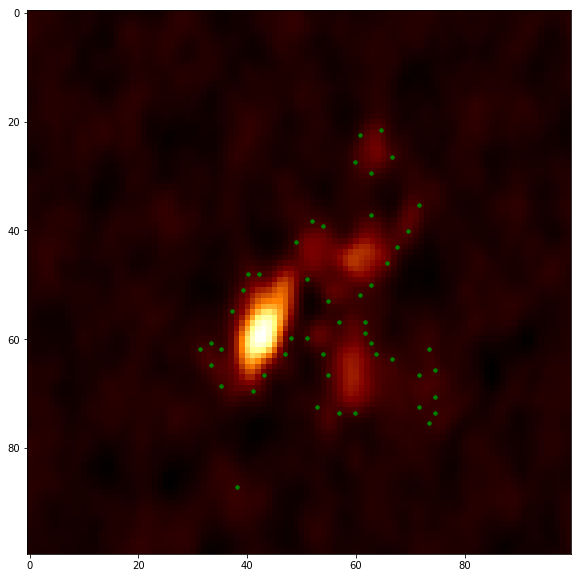

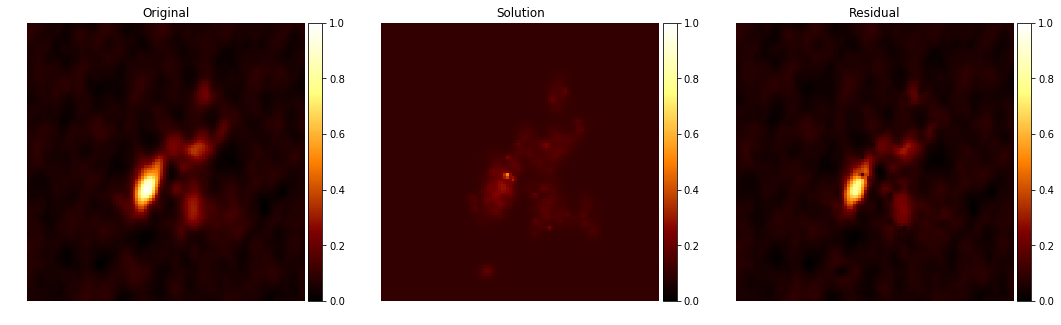

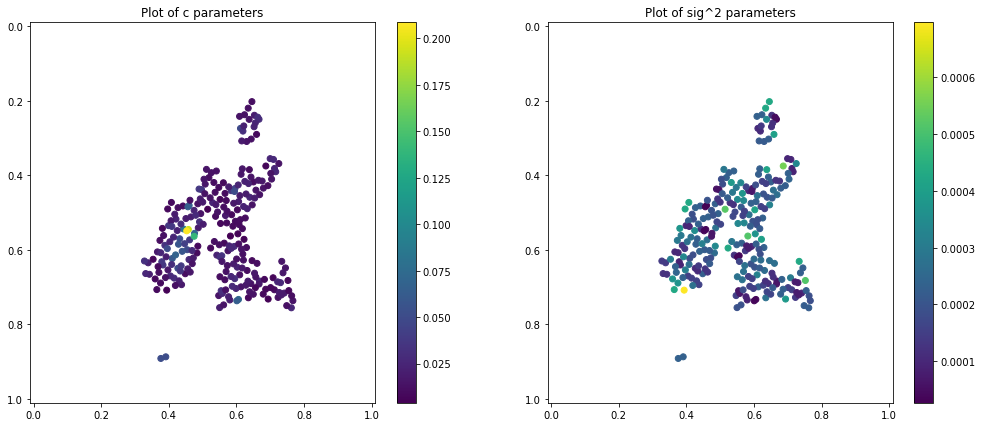

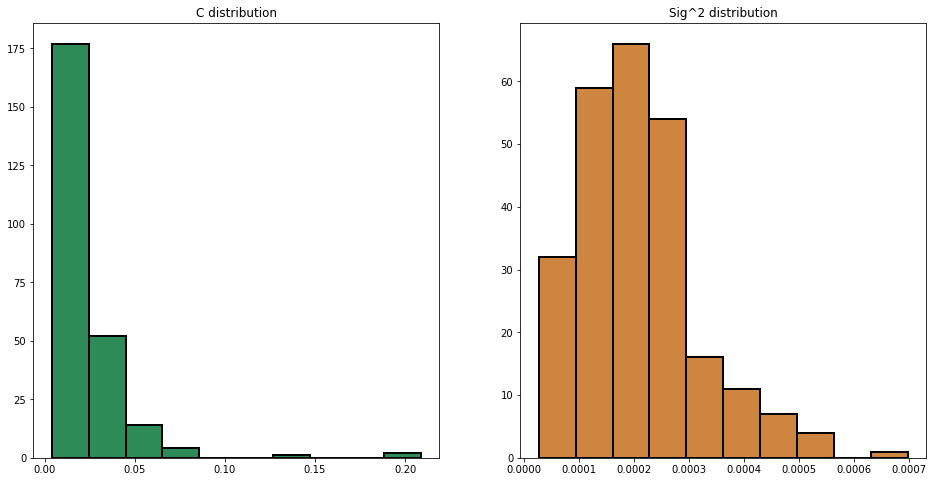

In [4]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100119

Residual stats:
Residual RMS: 0.004340645572955955
Residual Variance: 1.7623789643061673e-05
Flux Lost: 0.009535600910255643
Flux Addition: 0.004371740356189416
psi1(u-f): 0.0003580692807950652
Exceeded Pixels: 384
Sharpness: 45.57966444120587
psi2(grad u): 3.871948951460351
Total elapsed time: 303.2333209514618 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.021478957611357354
Mean min distance between collocation and center points: 0.008294016638191157

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06274804368557955
Max min distance in the (standarized) parameters space: 0.23776409995501332


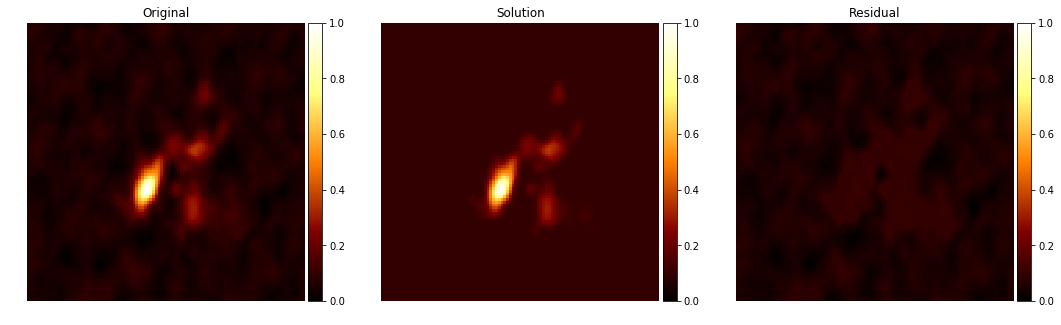

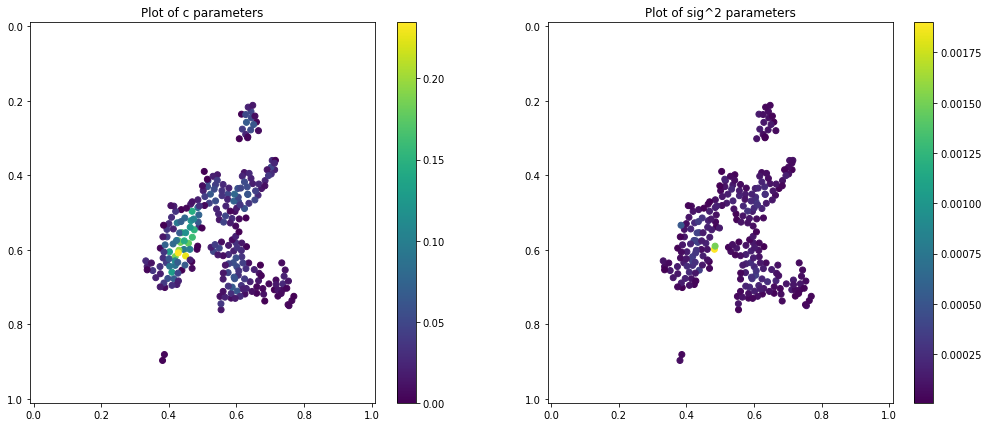

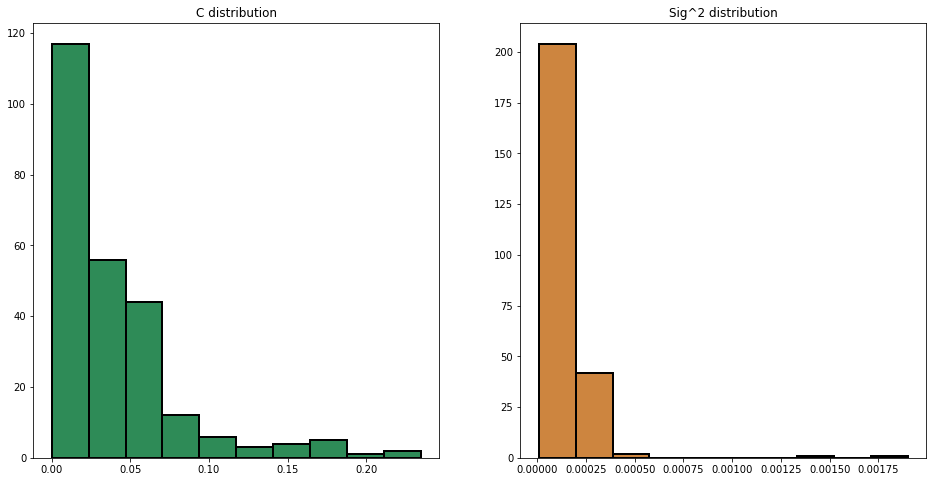

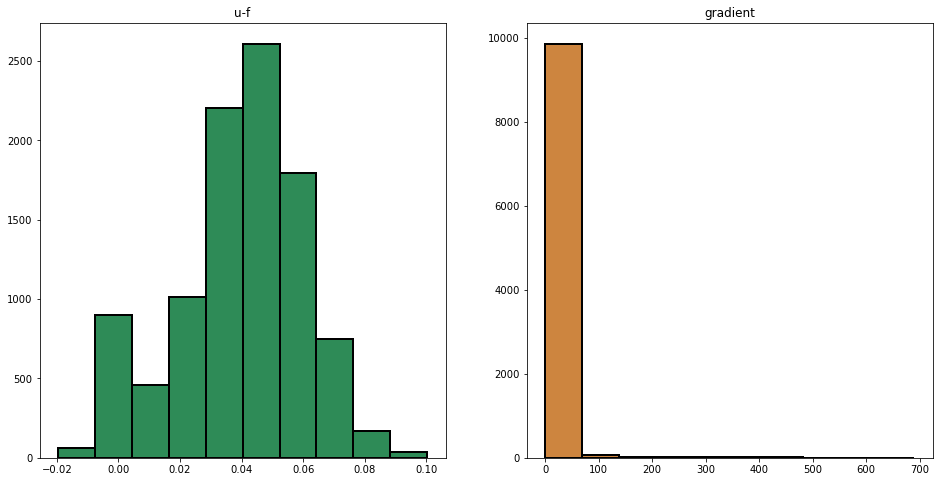

In [5]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [6]:
elm01.prune()
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

### Agglomeration with `KL-divergence` (upper bound)

In [7]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 106 and 231 with 1.1482965085926726e-07 KL dist and 5.006046626570673e-12 ISD dist
Merged components 1 and 106 with 1.6627893930097997e-07 KL dist and 1.3232312212674345e-11 ISD dist
Merged components 64 and 137 with 2.4930670130933214e-07 KL dist and 1.3572576894276007e-10 ISD dist
Merged components 11 and 166 with 3.889722973950932e-07 KL dist and 2.4409025137792595e-10 ISD dist
Merged components 5 and 47 with 4.98605903334742e-07 KL dist and 1.6277266254130285e-10 ISD dist
Merged components 0 and 29 with 5.48509918642259e-07 KL dist and 3.3665900788007205e-10 ISD dist
Merged components 117 and 156 with 5.584127916294517e-07 KL dist and 9.718514396983292e-11 ISD dist
Merged components 66 and 215 with 5.933031181681585e-07 KL dist and 6.470017998075346e-10 ISD dist
Merged components 0 and 135 with 6.282290911023114e-07 KL dist and 1.9542684119918607e-10 ISD dist
Merged components 30 and 102 with 6.660824345299681e-07 KL dist and 8.257527590383842e-11 ISD dist
Merged 

Merged components 58 and 88 with 7.820772827334669e-06 KL dist and 9.923931402020675e-10 ISD dist
Merged components 101 and 103 with 7.839766175144302e-06 KL dist and 4.128659656666849e-09 ISD dist
Merged components 113 and 115 with 7.993812106808223e-06 KL dist and 4.535987583703018e-09 ISD dist
Merged components 26 and 38 with 8.001116198892624e-06 KL dist and 9.018171903015254e-09 ISD dist
Merged components 75 and 88 with 8.12975173881142e-06 KL dist and 3.18439597613425e-08 ISD dist
Merged components 8 and 37 with 8.588737569711436e-06 KL dist and 9.38330257106237e-09 ISD dist
Merged components 14 and 82 with 8.729513341837968e-06 KL dist and 1.4849714388416671e-08 ISD dist
Merged components 35 and 87 with 8.792195873784308e-06 KL dist and 6.919189074530146e-09 ISD dist
Merged components 55 and 82 with 8.902317691456601e-06 KL dist and 1.2763123357938087e-08 ISD dist
Merged components 30 and 119 with 8.985950023784937e-06 KL dist and 6.1303032034413294e-09 ISD dist
Merged component

Merged components 9 and 20 with 4.715554555041724e-05 KL dist and 1.5647884898311857e-07 ISD dist
Merged components 20 and 52 with 4.786894109231636e-05 KL dist and 2.2796348426666468e-07 ISD dist
Merged components 5 and 46 with 4.790348787202074e-05 KL dist and 9.455606048627417e-08 ISD dist
Merged components 6 and 16 with 4.792368549695218e-05 KL dist and 1.707315683121821e-07 ISD dist
Merged components 12 and 14 with 4.9058381618429664e-05 KL dist and 2.5312775930093446e-07 ISD dist
Merged components 7 and 41 with 4.99115809970618e-05 KL dist and 1.579900087459423e-07 ISD dist
Merged components 17 and 26 with 5.089786372908364e-05 KL dist and 1.2854180058050442e-07 ISD dist
Merged components 11 and 41 with 5.2212641726310485e-05 KL dist and 9.174846351069019e-08 ISD dist
Merged components 2 and 18 with 5.317501988604315e-05 KL dist and 8.02537266885776e-08 ISD dist
Merged components 1 and 3 with 5.3683921180654876e-05 KL dist and 6.353957468682489e-07 ISD dist
Merged components 3 an

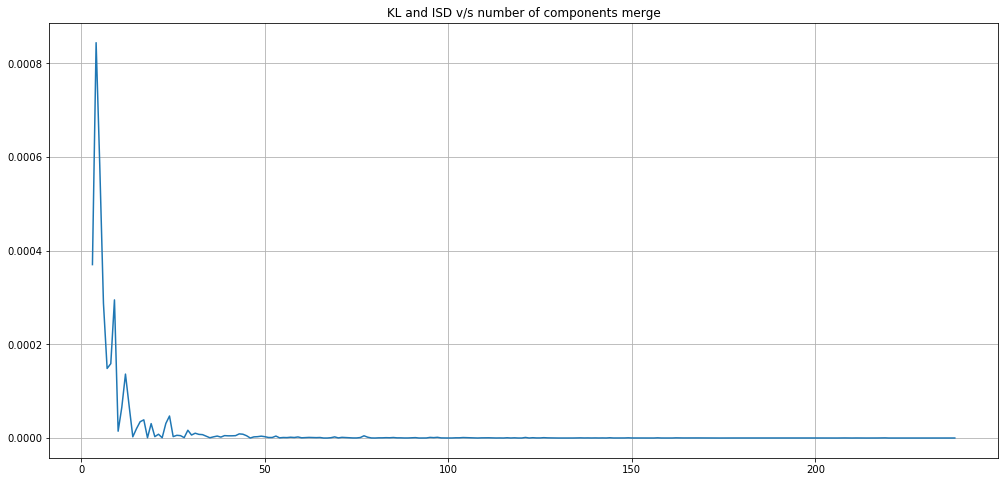

In [31]:
ncomp = list(range(len(isd_hist),0,-1))[0:-2]
y =  kl_hist[1:-1] - kl_hist[0:-2]
plt.figure(figsize=(17,8))
#plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.plot(ncomp, y)
#plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()



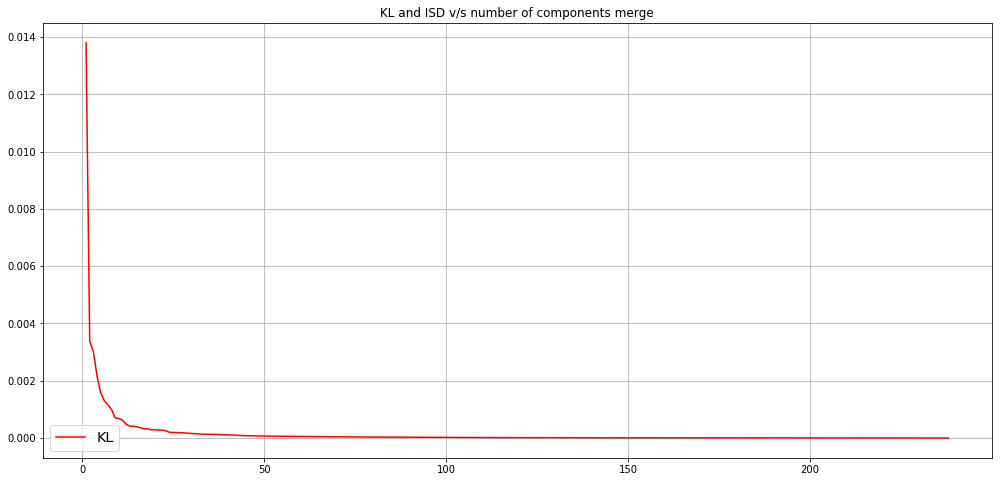

In [33]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
#plt.plot(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.plot(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [22]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

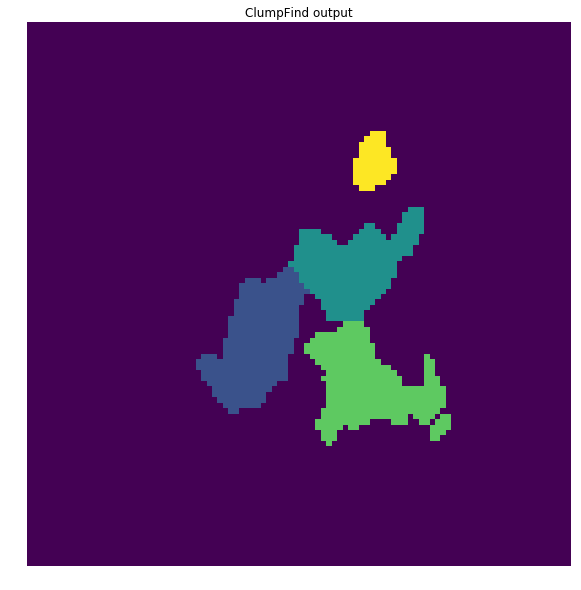

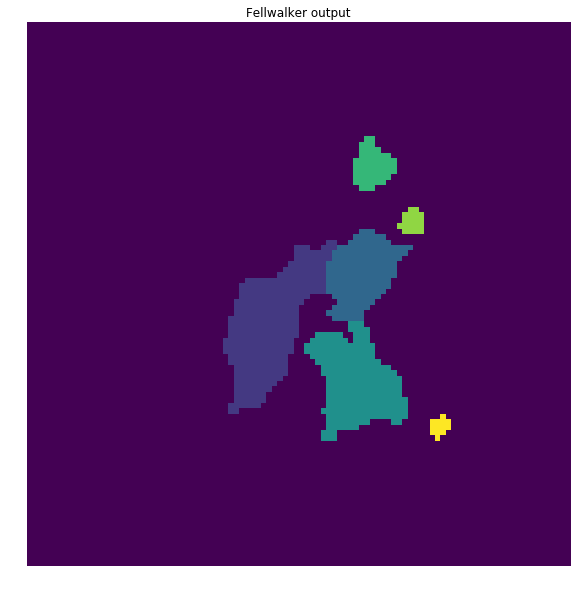

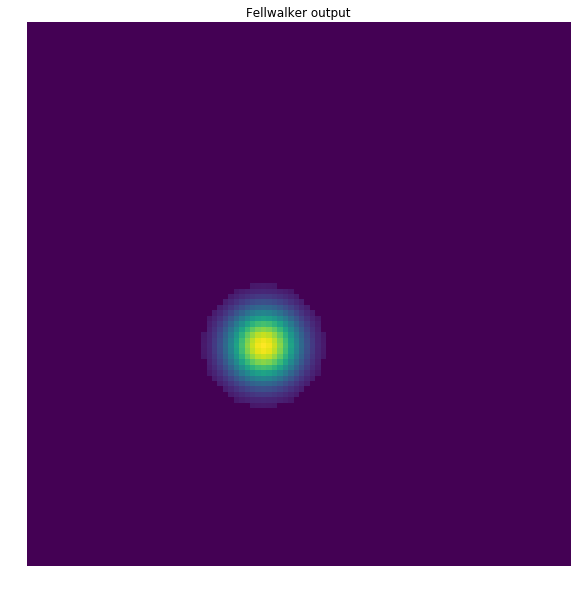

In [110]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

out_gc = gaussclumps(data, 0.9*base_level)
out_gc[out_gc==out_gc.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_gc.T)
plt.axis('off')
plt.show()

### Agglomeration with `ISD`

$$
d_{\textit{ISD}}(i,j) = \int_{\Omega} \left( (w_i \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, \Sigma_i) + w_j \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_j, \Sigma_j) ) - (w_m \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_m, \Sigma_m))  \right)^2 d\mathbf{x}
$$

In [8]:
components_dict02, isd_hist02, kl_hist02 = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD', verbose=True)

Merged components 113 and 186 with 4.645467495921485e-16 ISD dist
Merged components 88 and 200 with 6.450809908232379e-12 ISD dist
Merged components 13 and 143 with 7.89530467049717e-12 ISD dist
Merged components 218 and 232 with 1.064025696467997e-11 ISD dist
Merged components 138 and 234 with 1.767091442112954e-11 ISD dist
Merged components 23 and 187 with 3.3328211060053064e-11 ISD dist
Merged components 105 and 146 with 5.219774897256288e-11 ISD dist
Merged components 106 and 134 with 7.125463080292838e-11 ISD dist
Merged components 121 and 209 with 1.073379376401084e-10 ISD dist
Merged components 51 and 222 with 1.1383190951908985e-10 ISD dist
Merged components 1 and 92 with 1.37728893712791e-10 ISD dist
Merged components 138 and 217 with 1.6723446065183328e-10 ISD dist
Merged components 6 and 70 with 2.2583451085650072e-10 ISD dist
Merged components 23 and 138 with 3.3869581990003943e-10 ISD dist
Merged components 161 and 220 with 3.8686165696522653e-10 ISD dist
Merged components

Merged components 15 and 106 with 2.7214736432924486e-08 ISD dist
Merged components 7 and 52 with 2.7661878611104368e-08 ISD dist
Merged components 38 and 99 with 2.7897089854336178e-08 ISD dist
Merged components 0 and 44 with 2.8226223963992043e-08 ISD dist
Merged components 24 and 101 with 2.851777117838938e-08 ISD dist
Merged components 2 and 32 with 3.0231472014572745e-08 ISD dist
Merged components 12 and 28 with 3.155285833980816e-08 ISD dist
Merged components 13 and 26 with 3.203352232000007e-08 ISD dist
Merged components 33 and 71 with 3.4592631223400767e-08 ISD dist
Merged components 24 and 48 with 3.562362482094652e-08 ISD dist
Merged components 16 and 36 with 3.5659780349221664e-08 ISD dist
Merged components 6 and 61 with 3.5820331314366215e-08 ISD dist
Merged components 15 and 22 with 4.030286743723479e-08 ISD dist
Merged components 6 and 27 with 4.1519320572154807e-08 ISD dist
Merged components 1 and 7 with 4.152831040690016e-08 ISD dist
Merged components 13 and 99 with 3.1

In [37]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict02), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

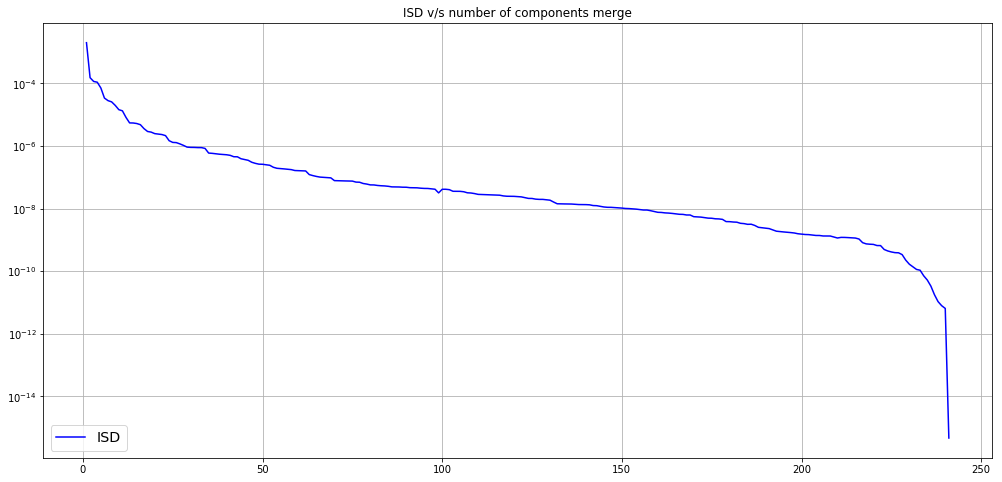

In [18]:
ncomp = list(range(len(isd_hist02),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, isd_hist02, "b-", label='ISD')
plt.title("ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with normalized `ISD`

$$
d_{\textit{ISD}}(i,j) = \int_{\Omega} \left( (\frac{w_i}{w_m} \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, \Sigma_i) + \frac{w_j}{w_m} \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_j, \Sigma_j) ) - (\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_m, \Sigma_m))  \right)^2 d\mathbf{x}
$$

In [19]:
components_dict03, isd_hist03, kl_hist03 = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD_', verbose=True)

Merged components 113 and 186 with 2.516250674489129e-08 ISD dist
Merged components 13 and 144 with 0.00035309987396203724 ISD dist
Merged components 1 and 95 with 0.000610316306307368 ISD dist
Merged components 137 and 236 with 0.0009564100779755336 ISD dist
Merged components 135 and 236 with 0.0011440539599902877 ISD dist
Merged components 19 and 54 with 0.0034889564732623057 ISD dist
Merged components 21 and 183 with 0.003658727306003584 ISD dist
Merged components 83 and 190 with 0.005201376046443329 ISD dist
Merged components 119 and 208 with 0.00657000033913846 ISD dist
Merged components 29 and 100 with 0.006682448443143585 ISD dist
Merged components 6 and 68 with 0.006813257544308726 ISD dist
Merged components 22 and 139 with 0.007644989375933164 ISD dist
Merged components 135 and 222 with 0.008772852007012943 ISD dist
Merged components 77 and 228 with 0.01039313148945098 ISD dist
Merged components 0 and 75 with 0.01343718886306533 ISD dist
Merged components 45 and 213 with 0.015

Merged components 10 and 109 with 0.0790699920938458 ISD dist
Merged components 32 and 108 with 0.07801296998128215 ISD dist
Merged components 42 and 107 with 0.07916214265821786 ISD dist
Merged components 39 and 106 with 0.07946464241950046 ISD dist
Merged components 18 and 105 with 0.07915192412905903 ISD dist
Merged components 44 and 104 with 0.08204218882210412 ISD dist
Merged components 12 and 103 with 0.08222796739587324 ISD dist
Merged components 58 and 102 with 0.08706322453996229 ISD dist
Merged components 36 and 101 with 0.08741739122778469 ISD dist
Merged components 27 and 100 with 0.08804615917541803 ISD dist
Merged components 24 and 99 with 0.08540914960346768 ISD dist
Merged components 54 and 98 with 0.0845250114196201 ISD dist
Merged components 72 and 97 with 0.08328295300730204 ISD dist
Merged components 32 and 96 with 0.08062606474499745 ISD dist
Merged components 46 and 95 with 0.06429089472256422 ISD dist
Merged components 68 and 94 with 0.07616543093105932 ISD dist


In [20]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

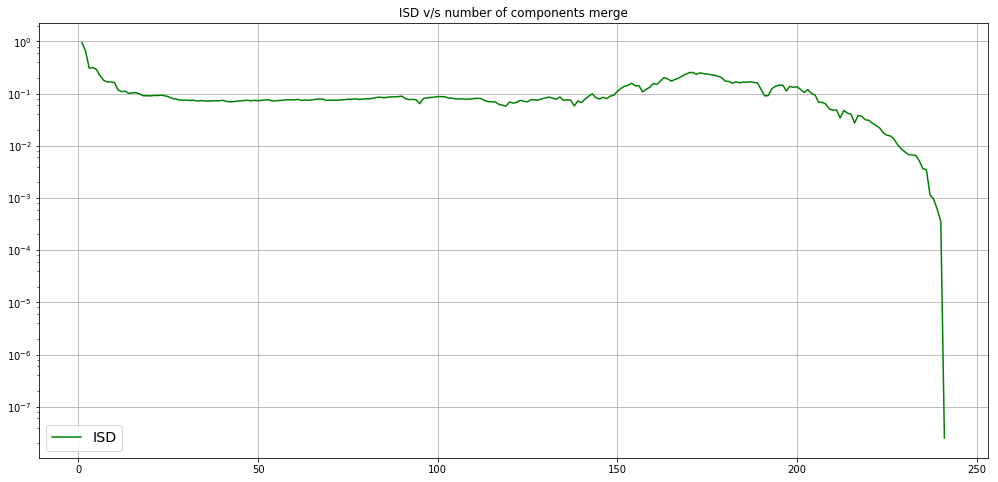

In [21]:
ncomp = list(range(len(isd_hist03),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, isd_hist03, "g-", label='ISD')
plt.title("ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

### Agglomeration with `ISD`: Maray's Approach

In [11]:
components_dict04, isd_hist = gaussian_reduction_(w, mu, sig, n_comp=1, verbose=True)

Merged components 113 and 186 with 4.645467495921485e-16 ISD dist
Merged components 88 and 200 with 6.450809908232379e-12 ISD dist
Merged components 13 and 143 with 7.895304665414972e-12 ISD dist
Merged components 218 and 232 with 1.064025696467997e-11 ISD dist
Merged components 138 and 234 with 1.7653900330357158e-11 ISD dist
Merged components 23 and 187 with 3.3328211060053064e-11 ISD dist
Merged components 105 and 146 with 5.219774897256288e-11 ISD dist
Merged components 106 and 134 with 7.125463080303426e-11 ISD dist
Merged components 121 and 209 with 1.073379376324851e-10 ISD dist
Merged components 51 and 222 with 1.1383190951951336e-10 ISD dist
Merged components 1 and 92 with 1.3772889369923847e-10 ISD dist
Merged components 138 and 217 with 1.6723446065193916e-10 ISD dist
Merged components 6 and 70 with 2.258345108717473e-10 ISD dist
Merged components 23 and 138 with 3.3869581990342756e-10 ISD dist
Merged components 18 and 50 with 3.9139246096902723e-10 ISD dist
Merged component

Merged components 16 and 44 with 3.622803575722365e-08 ISD dist
Merged components 34 and 41 with 3.7956783963868365e-08 ISD dist
Merged components 37 and 68 with 3.9967601431056906e-08 ISD dist
Merged components 17 and 25 with 4.030286743723479e-08 ISD dist
Merged components 5 and 41 with 4.0499638212035676e-08 ISD dist
Merged components 41 and 65 with 4.143514565942028e-08 ISD dist
Merged components 1 and 7 with 4.152831040689677e-08 ISD dist
Merged components 5 and 28 with 4.1975456676759516e-08 ISD dist
Merged components 4 and 24 with 4.422835261791972e-08 ISD dist
Merged components 9 and 72 with 4.506918960294488e-08 ISD dist
Merged components 13 and 25 with 4.5193546557985596e-08 ISD dist
Merged components 19 and 22 with 4.6908901112707393e-08 ISD dist
Merged components 13 and 80 with 4.741078041094131e-08 ISD dist
Merged components 25 and 71 with 4.784860758792178e-08 ISD dist
Merged components 20 and 63 with 4.8394010530671865e-08 ISD dist
Merged components 2 and 23 with 5.01600

In [12]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict04), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

### Agglomeration with `ISD`: Original William's Approach

In [ ]:
# WARNING: Running this cell takes an indetermined amount of time
components_dict05, isd_hist = gaussian_reduction__(w, mu, sig, n_comp=1, verbose=True)

## Conclusion: `Use the KL-divergence (upper bound), Runall approach. `

***
***

# `M100`

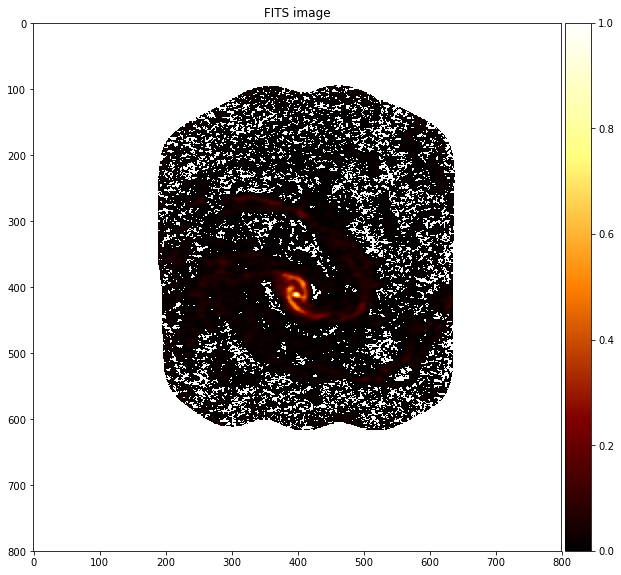

In [2]:
"""
Loading data
"""

fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [3]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

# Experiment: Generating an `ELM` instance

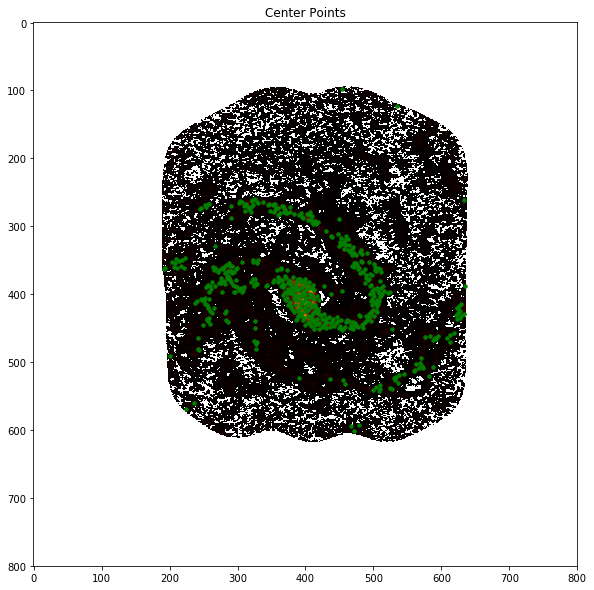

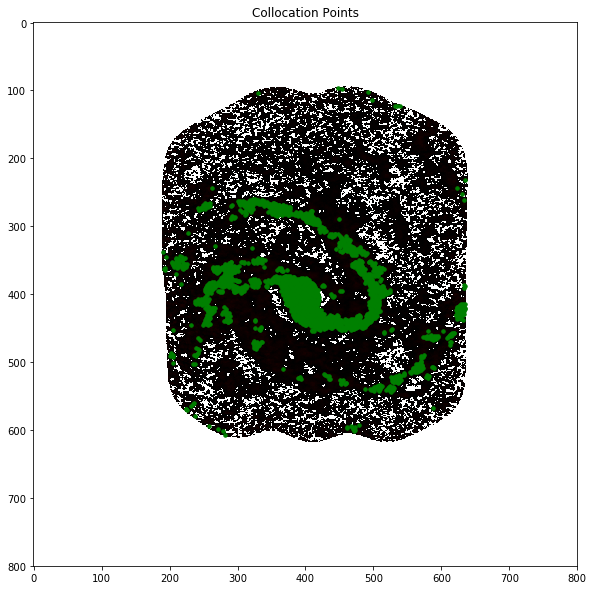

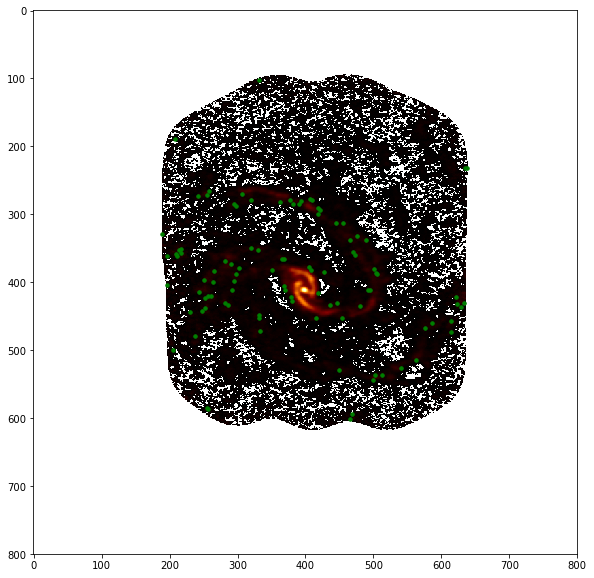

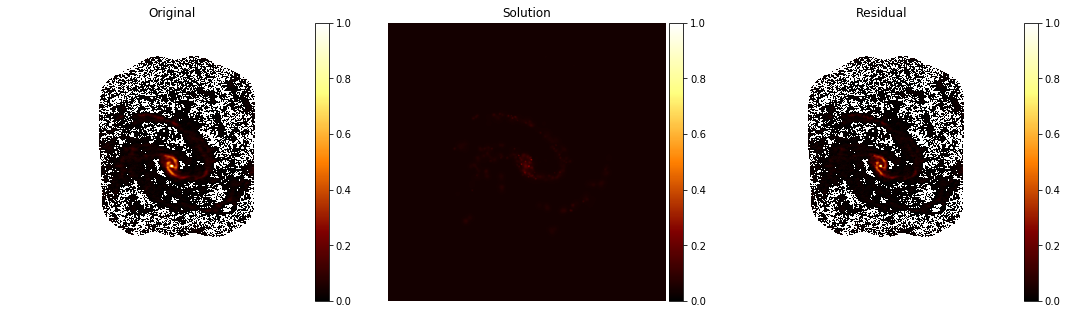

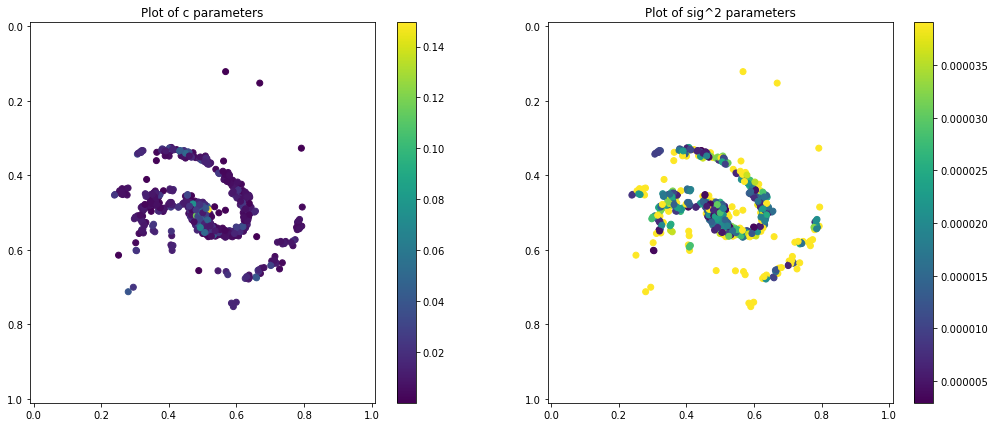

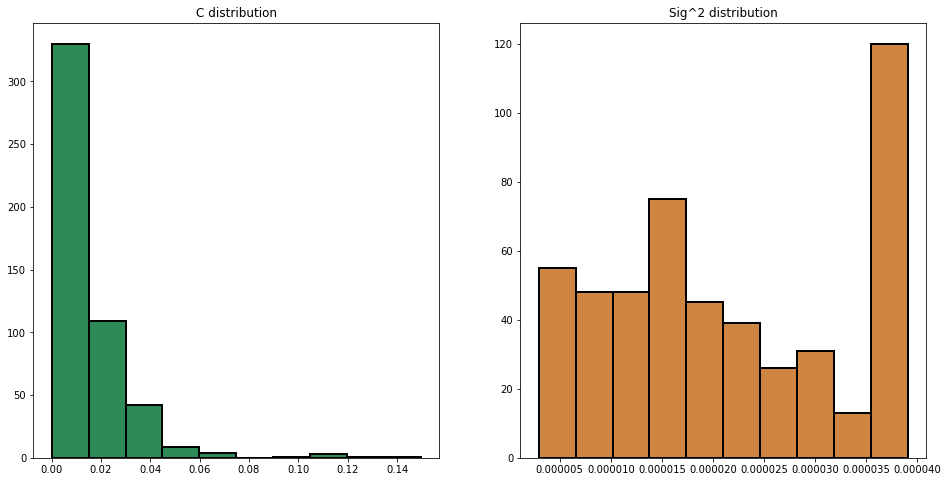

In [26]:
Nc = 500
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm02 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: True
status: 4
message: The cosine of the angle between func(x) and any column of the
  Jacobian is at most 0.000000 in absolute value
nfev: 2201

Residual stats:
Residual RMS: 0.0891280062737604
Residual Variance: 0.006710452613247808
Flux Lost: 0.37827865582606085
Flux Addition: 0.0338316340402007
psi1(u-f): 0.13531027019251596
Exceeded Pixels: 5373
Sharpness: 112.89124511362827
psi2(grad u): 0.36966838672108393
Total elapsed time: 24.372447967529297 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.14813428570245013
Mean min distance between collocation and center points: 0.003143007774651054

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.033379338652740204
Max min distance in the (standa

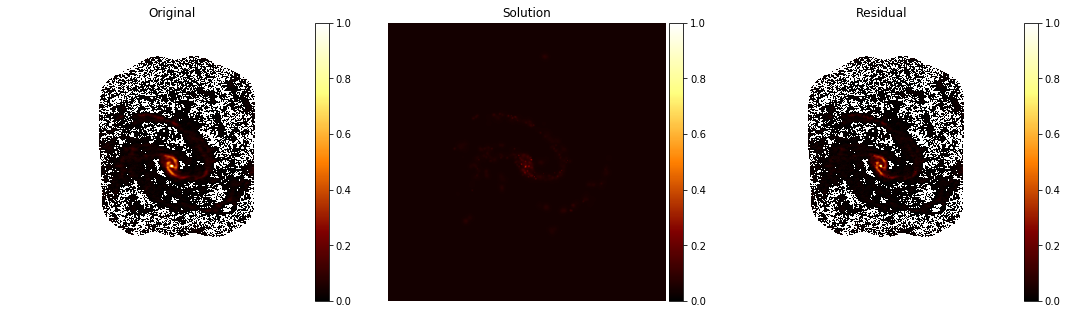

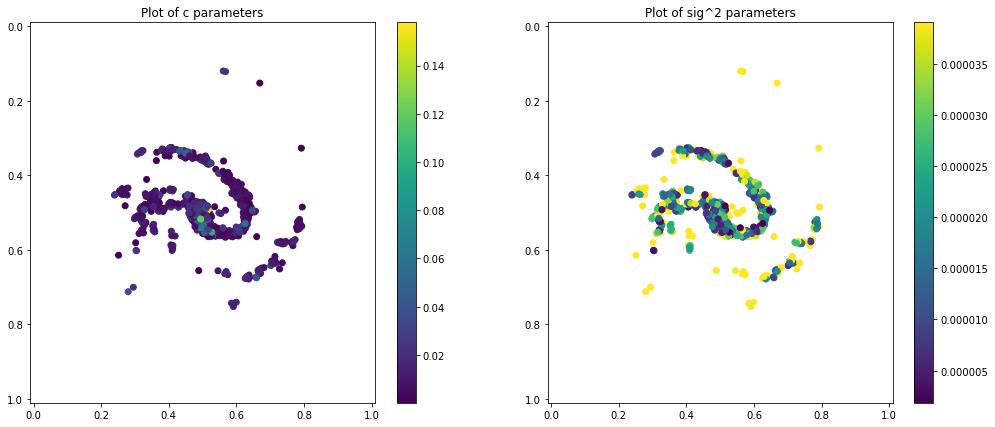

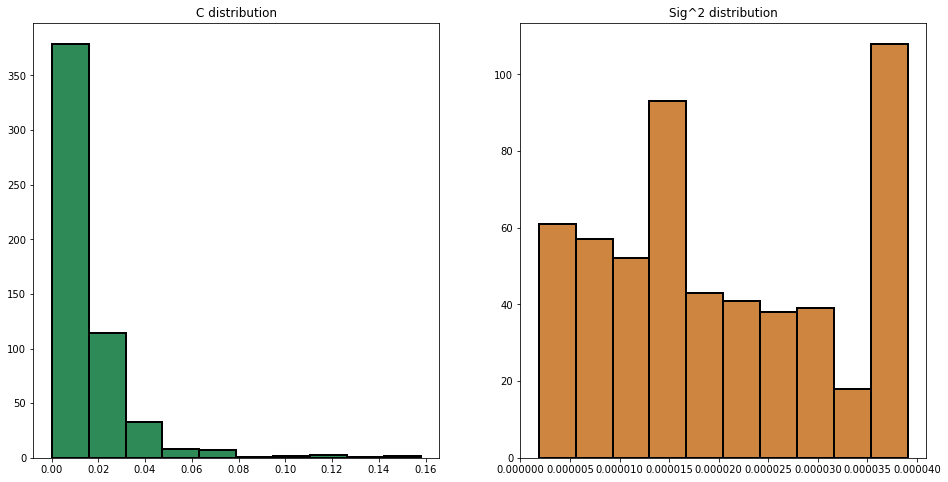

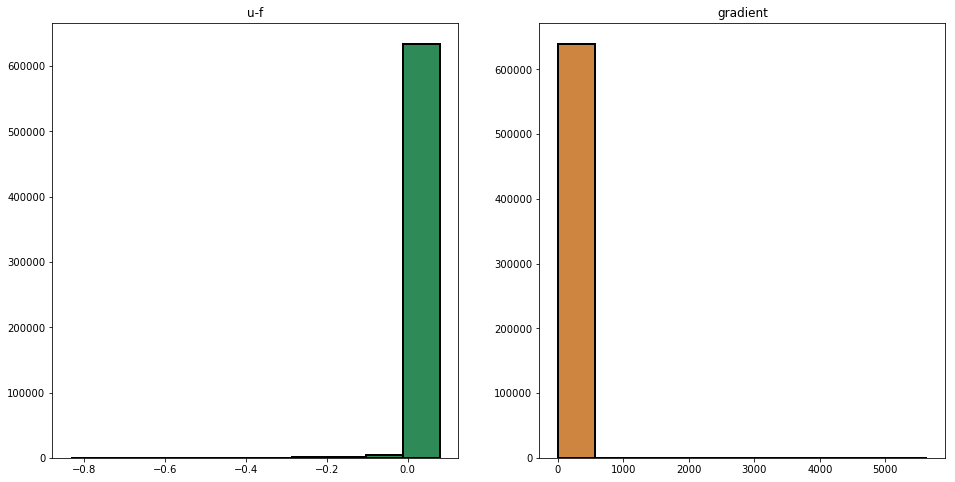

In [24]:
nfev = 100*(len(elm02.get_params())+1)
elm_solver(elm02, method='standard', max_nfev=nfev)

In [22]:
elm02.f0.min()

0.0424763647408802

In [18]:
xc, yc, c, sig = elm02.get_params_mapped()
xc

0.12225341796875

In [42]:
elm02.prune()
xc, yc, c, sig = elm02.get_params_mapped()
w = elm02.get_w()
mu = np.vstack([xc, yc]).T

In [43]:
components_dict02, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 58 and 116 with 4.720602222033718e-09 KL dist and 4.859900328498124e-15 ISD dist
Merged components 37 and 165 with 5.1027658130079884e-09 KL dist and 1.0227368878548172e-14 ISD dist
Merged components 5 and 203 with 6.479415443131869e-09 KL dist and 1.5211535835227741e-13 ISD dist
Merged components 127 and 194 with 1.1185104751820823e-08 KL dist and 3.1534078334229236e-13 ISD dist
Merged components 47 and 122 with 1.4849472650238548e-08 KL dist and 2.5236097040863314e-14 ISD dist
Merged components 82 and 144 with 1.535234836424645e-08 KL dist and 7.796095577699207e-12 ISD dist
Merged components 27 and 146 with 1.5393964625892405e-08 KL dist and 4.0918291801616675e-14 ISD dist
Merged components 4 and 104 with 1.9533036951899403e-08 KL dist and 6.878744671307349e-13 ISD dist
Merged components 62 and 111 with 1.9959641062136904e-08 KL dist and 9.890628197997756e-12 ISD dist
Merged components 146 and 197 with 3.0788272184974636e-08 KL dist and 3.7907814380051305e-11 ISD di

Merged components 50 and 81 with 1.5538468721615665e-06 KL dist and 2.3214813521761386e-09 ISD dist
Merged components 77 and 90 with 1.566398361617827e-06 KL dist and 1.403292683227128e-09 ISD dist
Merged components 60 and 76 with 1.6046620024066759e-06 KL dist and 2.329606362968284e-09 ISD dist
Merged components 27 and 120 with 1.640570833220872e-06 KL dist and 2.879262519315221e-10 ISD dist
Merged components 26 and 80 with 1.6841073518186436e-06 KL dist and 3.6657344548328988e-09 ISD dist
Merged components 18 and 103 with 1.915096854169959e-06 KL dist and 4.0777514367856304e-10 ISD dist
Merged components 14 and 97 with 2.0132111373098206e-06 KL dist and 6.424923469664938e-09 ISD dist
Merged components 97 and 99 with 2.0293357287435427e-06 KL dist and 2.1941989311677537e-10 ISD dist
Merged components 69 and 111 with 2.033156575383883e-06 KL dist and 4.279297031043202e-09 ISD dist
Merged components 68 and 85 with 2.0664489693999235e-06 KL dist and 3.7089385336933946e-09 ISD dist
Merged

Merged components 3 and 7 with 3.11429783895011e-05 KL dist and 1.988384411650754e-07 ISD dist
Merged components 0 and 22 with 3.1610761804806524e-05 KL dist and 1.692984310355408e-07 ISD dist
Merged components 5 and 15 with 3.275034014138191e-05 KL dist and 7.903390542118734e-08 ISD dist
Merged components 5 and 17 with 3.5060895919837294e-05 KL dist and 1.4737249311667055e-07 ISD dist
Merged components 10 and 15 with 3.848035953397623e-05 KL dist and 9.1428466242769e-09 ISD dist
Merged components 0 and 1 with 4.156995022625606e-05 KL dist and 4.3932291233066416e-07 ISD dist
Merged components 6 and 14 with 4.429990166181222e-05 KL dist and 2.1586608400085034e-07 ISD dist
Merged components 14 and 21 with 4.447595420891582e-05 KL dist and 8.341505741279212e-09 ISD dist
Merged components 4 and 19 with 4.847593113548374e-05 KL dist and 1.5948290340091779e-07 ISD dist
Merged components 17 and 20 with 5.2995616803569256e-05 KL dist and 5.573650024549425e-08 ISD dist
Merged components 0 and 1

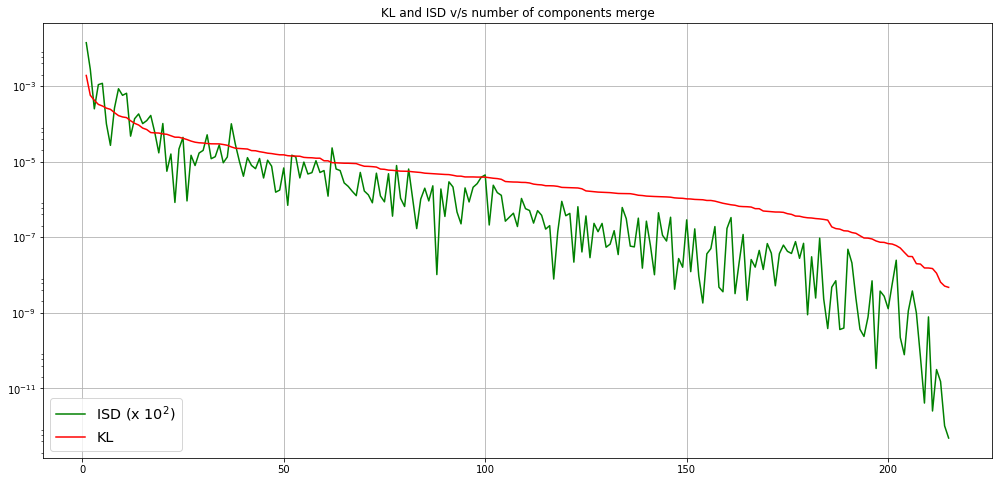

In [44]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [45]:
interact(components_plot, elm=fixed(elm02), data=fixed(data), components_dict=fixed(components_dict02), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

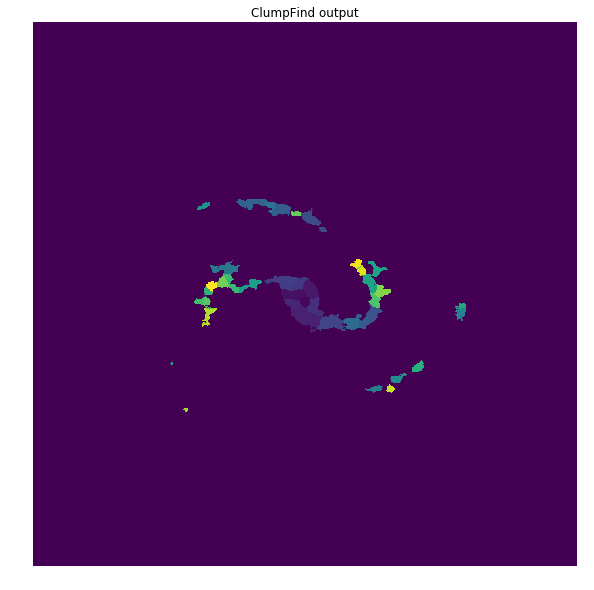

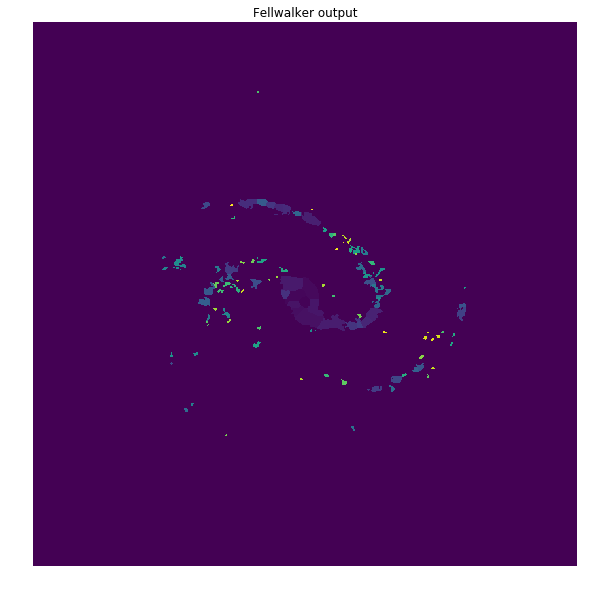

In [113]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

***
***

# `NGC3265`

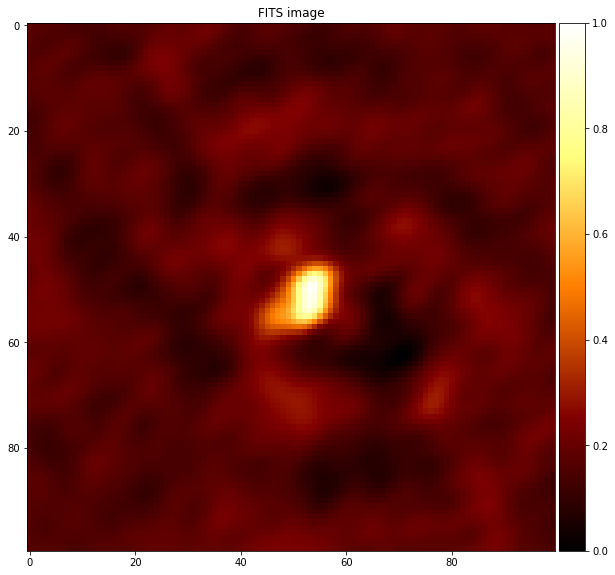

In [34]:
"""
Loading data
"""

fits_path = '../data/images/result-ngc3256_cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [35]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

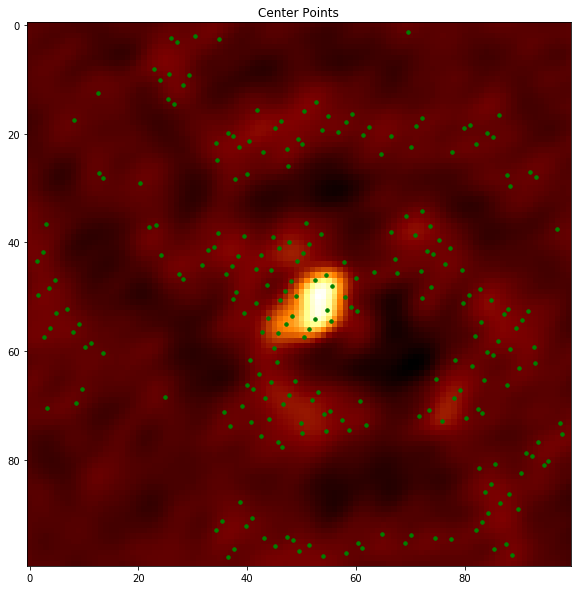

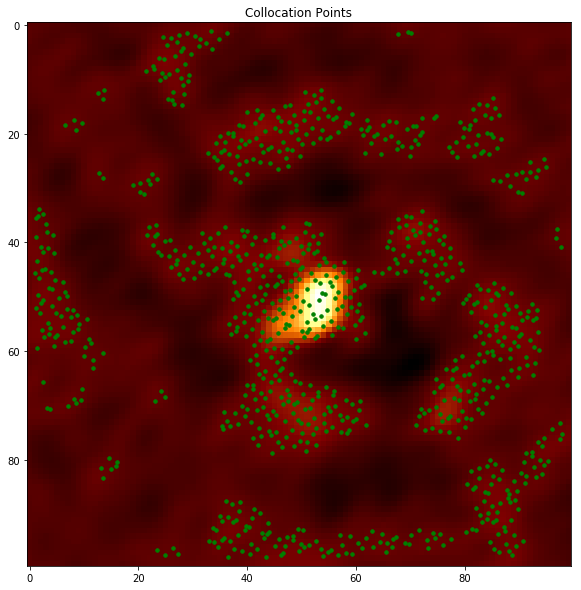

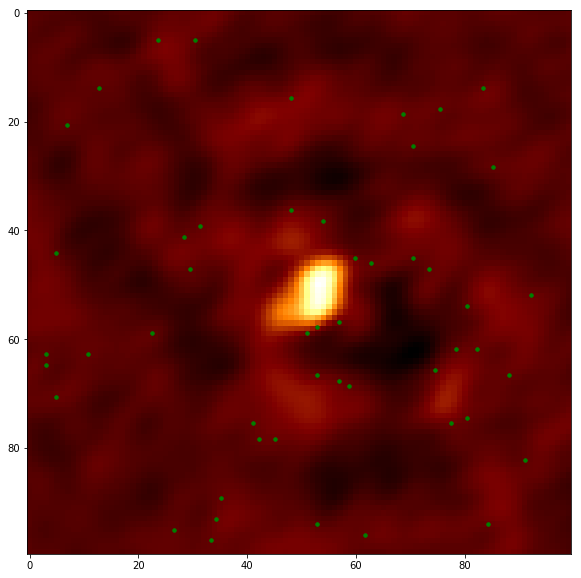

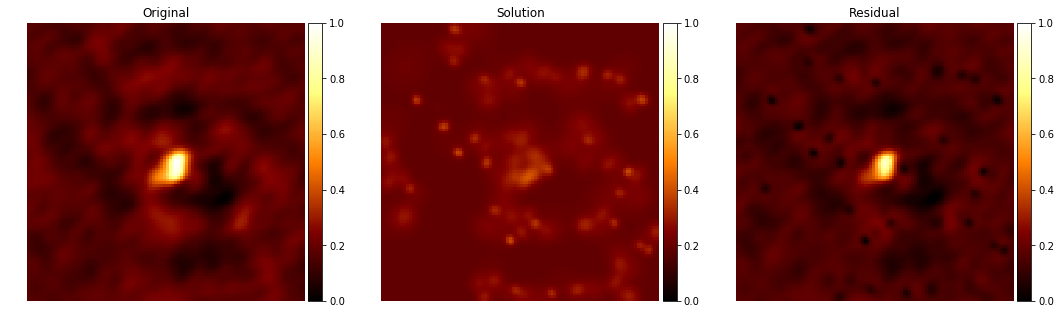

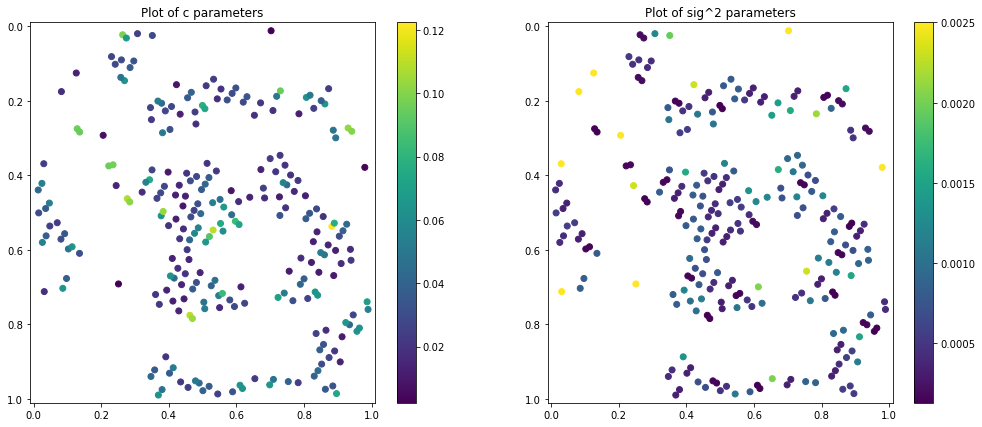

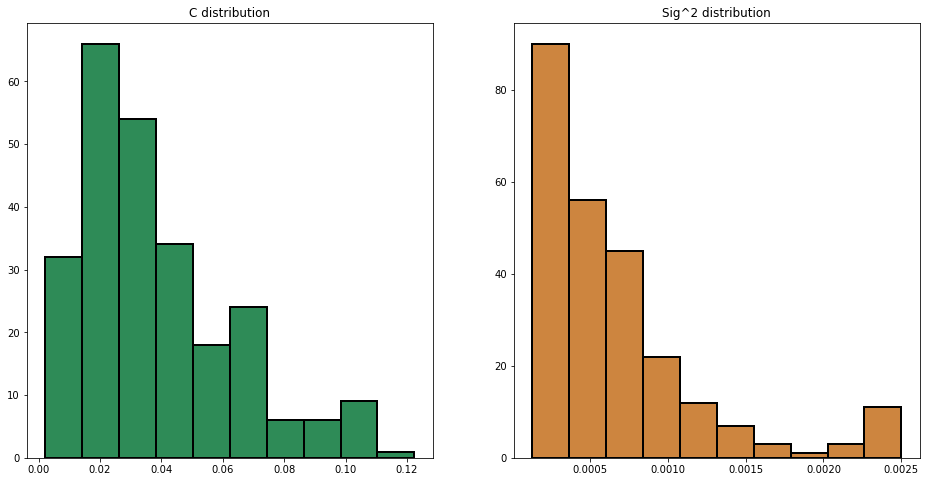

In [36]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm03 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100112

Residual stats:
Residual RMS: 0.005465719096929585
Residual Variance: 2.920581146946814e-05
Flux Lost: 0.009417370600032084
Flux Addition: 0.00593439885793406
psi1(u-f): 0.004857095303185438
Exceeded Pixels: 1269
Sharpness: 55.43016412342585
psi2(grad u): 2.7185031176838765
Total elapsed time: 206.28450107574463 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.14294354058000602
Mean min distance between collocation and center points: 0.015936534660185686

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.07879011075881405
Max min distance in the (standarized) parameters space: 0.3872589959149791


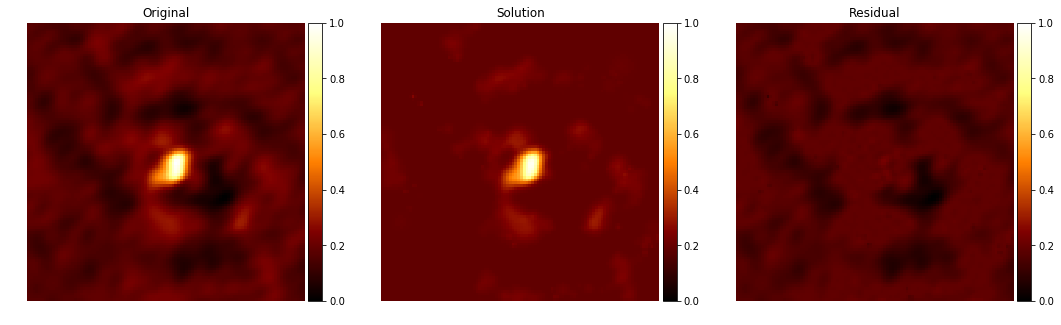

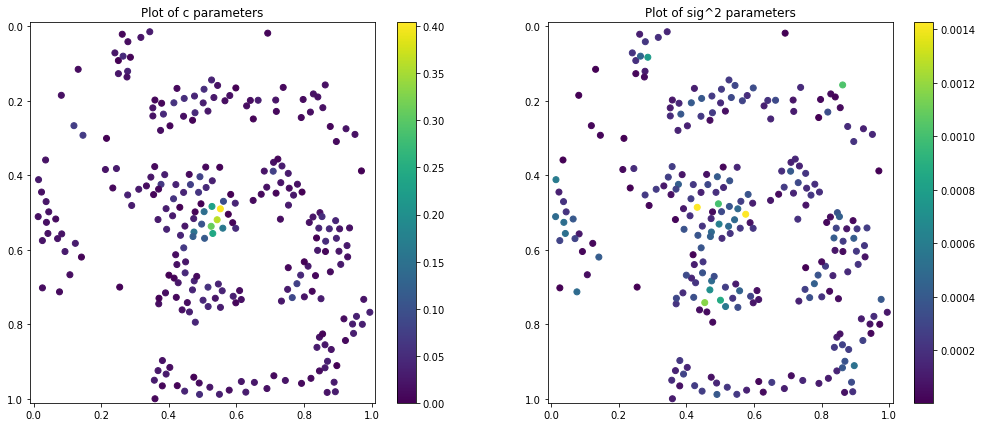

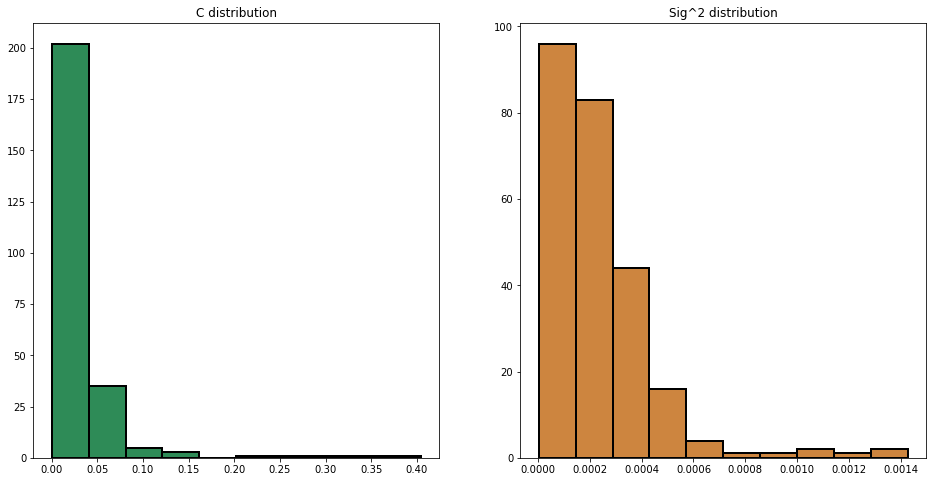

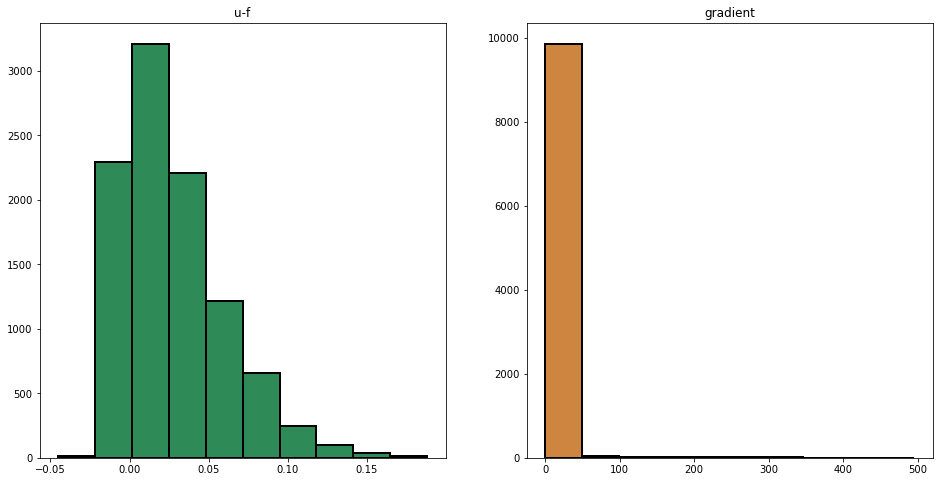

In [37]:
nfev = 100*(len(elm03.get_params())+1)
elm_solver(elm03, method='standard', max_nfev=nfev)

In [38]:
elm03.prune()
xc, yc, c, sig = elm03.get_params_mapped()
w = elm03.get_w()
mu = np.vstack([xc, yc]).T

In [39]:
components_dict03, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 97 and 124 with 6.197926030928474e-07 KL dist and 5.341422513436952e-11 ISD dist
Merged components 34 and 208 with 6.440818800740669e-07 KL dist and 3.4838077978760995e-11 ISD dist
Merged components 162 and 209 with 8.122238972531597e-07 KL dist and 8.311368702868931e-11 ISD dist
Merged components 158 and 213 with 8.968208134503941e-07 KL dist and 3.6454211882903113e-10 ISD dist
Merged components 45 and 125 with 9.056077438204286e-07 KL dist and 2.5034498525857745e-10 ISD dist
Merged components 69 and 152 with 1.0496339728871438e-06 KL dist and 8.6227360912713e-10 ISD dist
Merged components 114 and 144 with 1.1913386030608499e-06 KL dist and 8.048878141520811e-10 ISD dist
Merged components 96 and 114 with 1.248078852956998e-06 KL dist and 7.188642750045766e-10 ISD dist
Merged components 50 and 208 with 1.3765249117305792e-06 KL dist and 1.1435063876178226e-10 ISD dist
Merged components 61 and 140 with 1.4259457033681252e-06 KL dist and 4.079357631997293e-10 ISD dist
M

Merged components 27 and 76 with 1.7331430166172946e-05 KL dist and 1.0417784843354841e-07 ISD dist
Merged components 46 and 99 with 1.7576737196600608e-05 KL dist and 1.5947057267388766e-08 ISD dist
Merged components 47 and 126 with 1.8131942601098906e-05 KL dist and 1.4711875568957672e-08 ISD dist
Merged components 18 and 31 with 1.8385405356672918e-05 KL dist and 1.9226466015166587e-08 ISD dist
Merged components 26 and 122 with 1.8650287298130753e-05 KL dist and 3.659533556163098e-08 ISD dist
Merged components 36 and 103 with 1.870427751735754e-05 KL dist and 3.8860907385864456e-08 ISD dist
Merged components 0 and 24 with 1.8975961810328227e-05 KL dist and 2.6273661211136225e-08 ISD dist
Merged components 63 and 100 with 1.908968905113941e-05 KL dist and 6.185552794616897e-08 ISD dist
Merged components 22 and 64 with 1.945579706029145e-05 KL dist and 1.9719255583572737e-08 ISD dist
Merged components 61 and 129 with 2.0478955931106505e-05 KL dist and 3.975213140306245e-08 ISD dist
Me

Merged components 23 and 25 with 8.434556480515902e-05 KL dist and 3.061808320257469e-07 ISD dist
Merged components 12 and 15 with 9.314874434112426e-05 KL dist and 2.605205694263581e-07 ISD dist
Merged components 7 and 25 with 9.888890336885768e-05 KL dist and 1.2586799117500163e-07 ISD dist
Merged components 25 and 35 with 9.948371827420935e-05 KL dist and 2.7614492516459206e-07 ISD dist
Merged components 10 and 16 with 0.00010285844380593444 KL dist and 2.1392373817438471e-07 ISD dist
Merged components 11 and 15 with 0.0001058300429509273 KL dist and 6.862663443622967e-07 ISD dist
Merged components 16 and 30 with 0.00011091790192965518 KL dist and 4.923047996428189e-07 ISD dist
Merged components 8 and 9 with 0.00011304301778233058 KL dist and 1.043821541876615e-06 ISD dist
Merged components 4 and 31 with 0.0001159506695835174 KL dist and 4.05260695136194e-07 ISD dist
Merged components 7 and 46 with 0.00011910496858069707 KL dist and 3.923058810791926e-07 ISD dist
Merged components 1

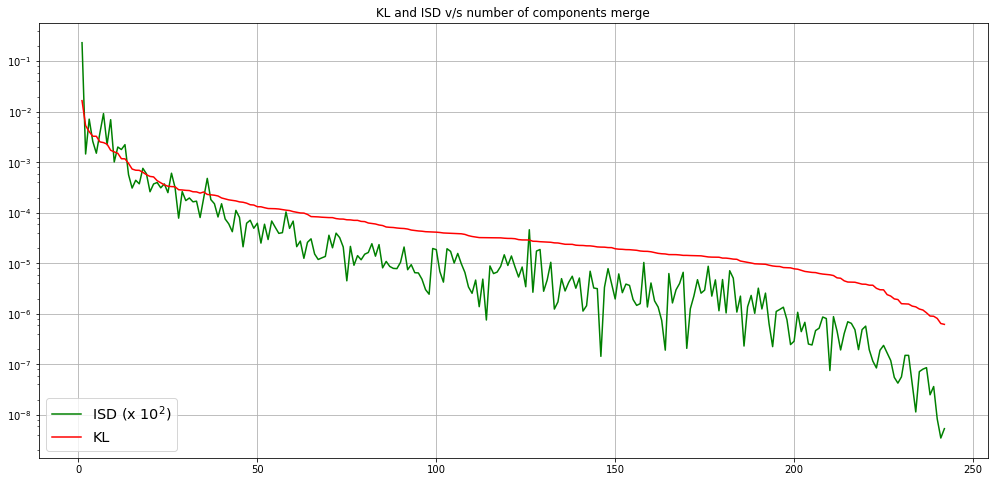

In [48]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [49]:
interact(components_plot, elm=fixed(elm03), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

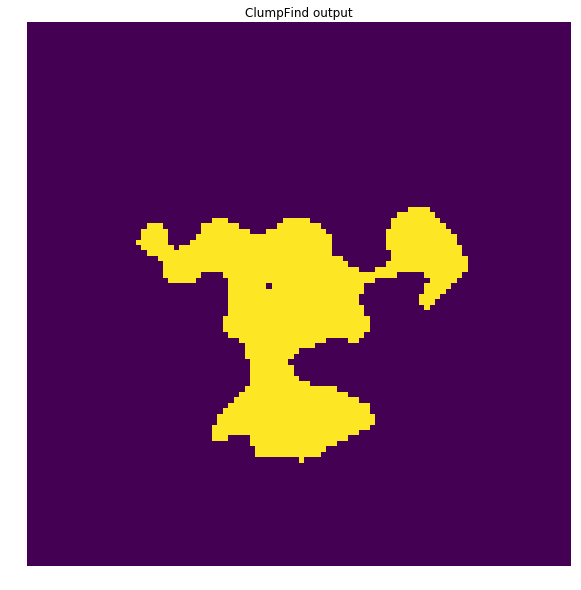

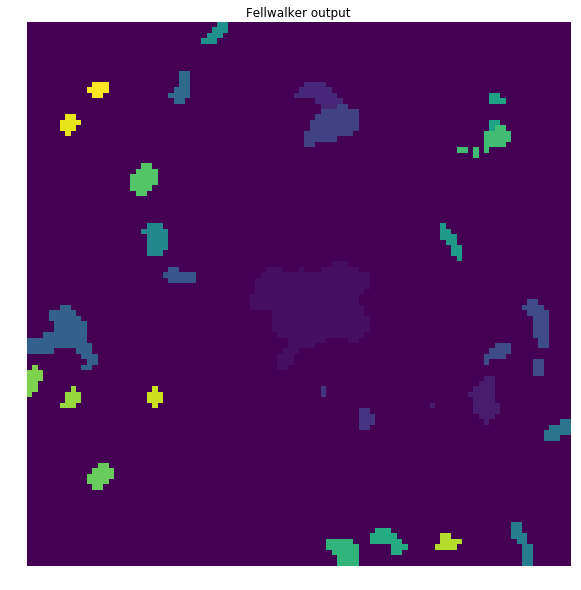

In [116]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

***
***
# `Antennae North`

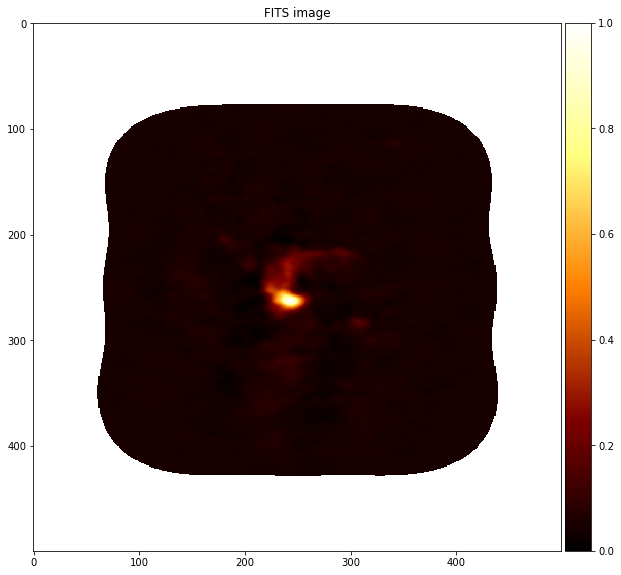

In [117]:
fits_path = '../data/images/Antennae_North.CO3_2Line.Clean.pcal1.image.mom0.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [118]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

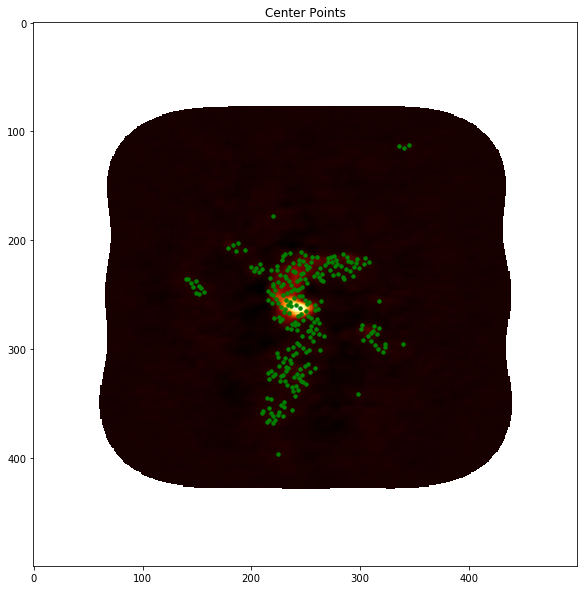

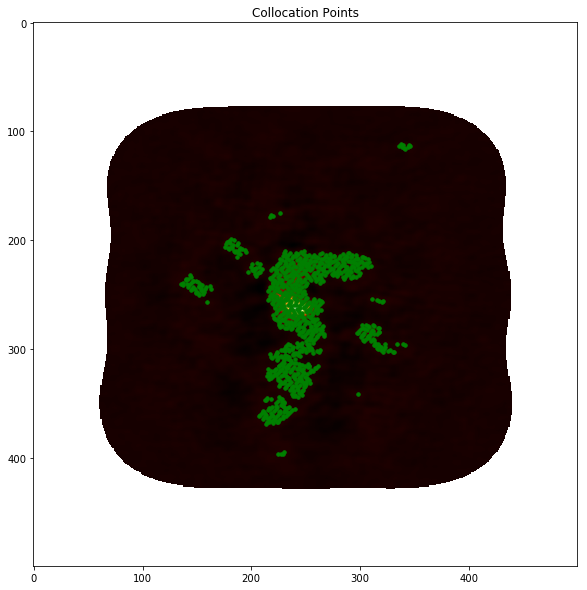

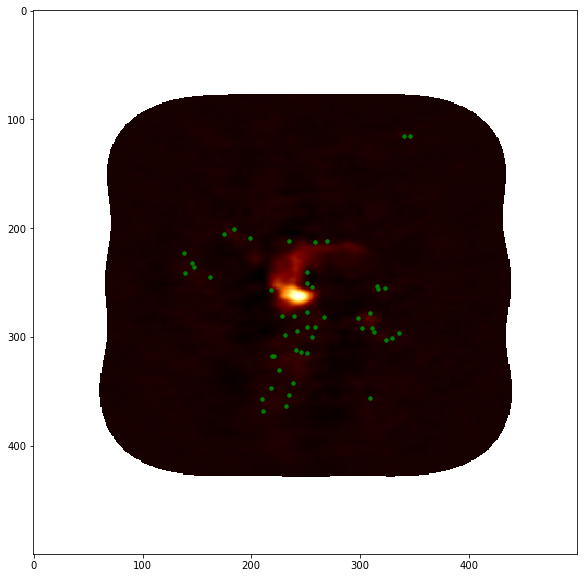

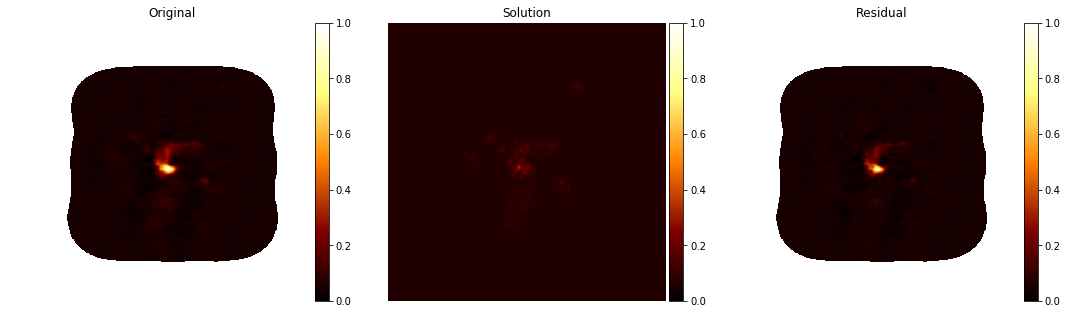

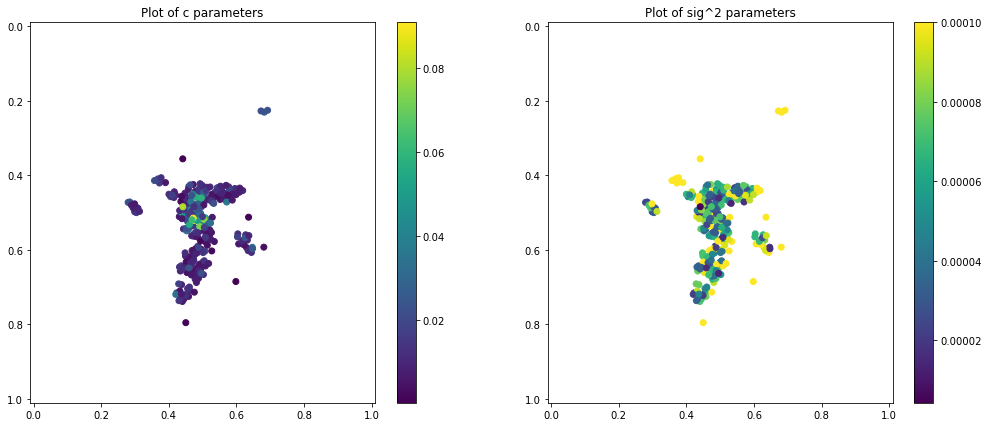

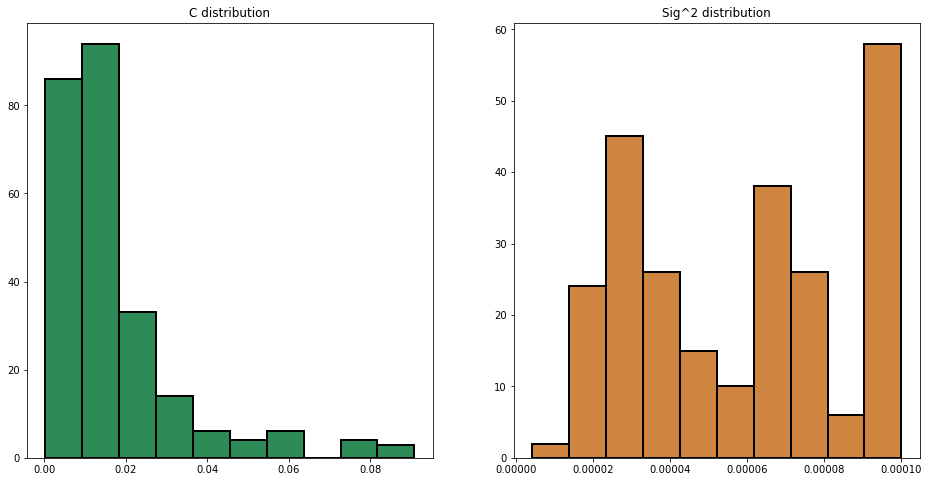

In [27]:
Nc = 250
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm04 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100108

Residual stats:
Residual RMS: 0.007323018698032352
Residual Variance: 5.331542932036504e-05
Flux Lost: 0.01819755870931587
Flux Addition: 0.01413462600056698
psi1(u-f): 0.02414638332232715
Exceeded Pixels: 3504
Sharpness: 93.89290303534662
psi2(grad u): 1.9915316344472789
Total elapsed time: 222.1721978187561 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.02046733423669602
Mean min distance between collocation and center points: 0.004714256360474031

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06644069841756589
Max min distance in the (standarized) parameters space: 0.3448759502223117


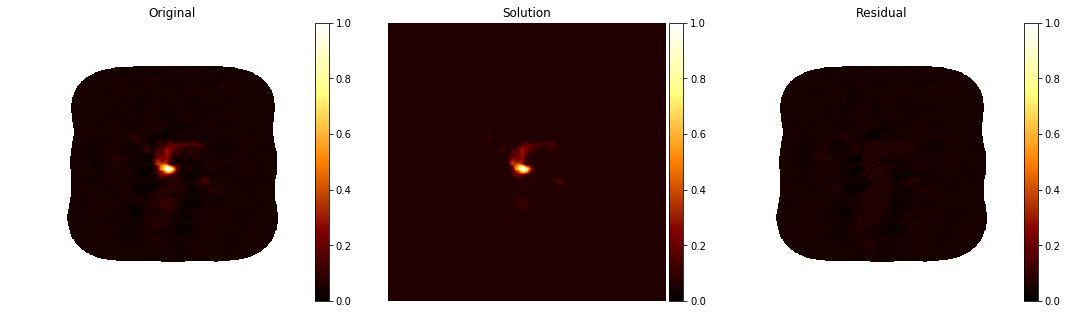

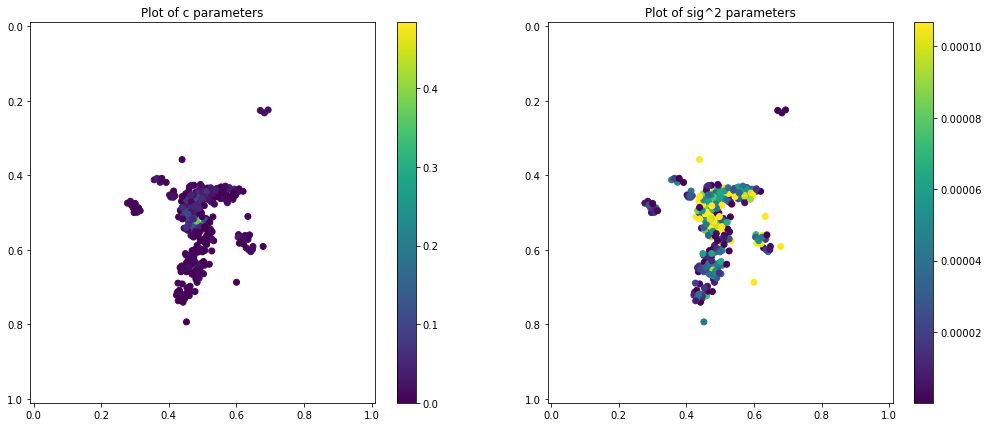

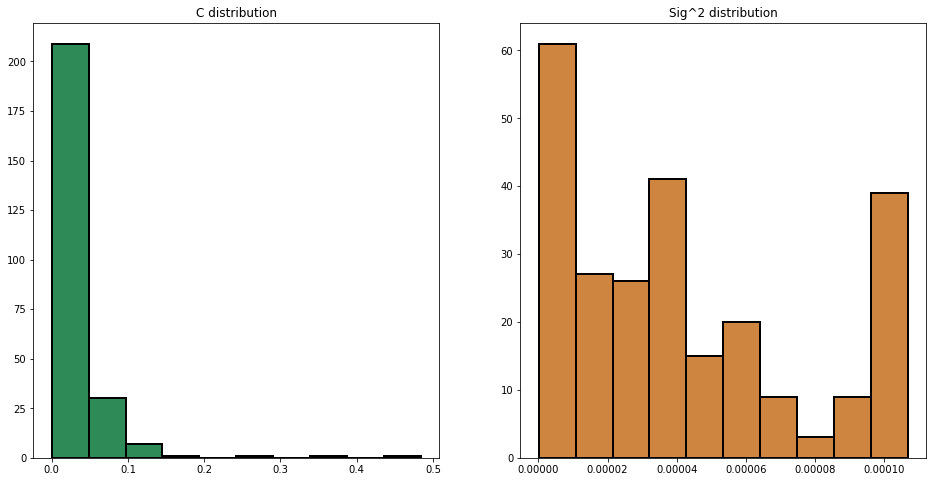

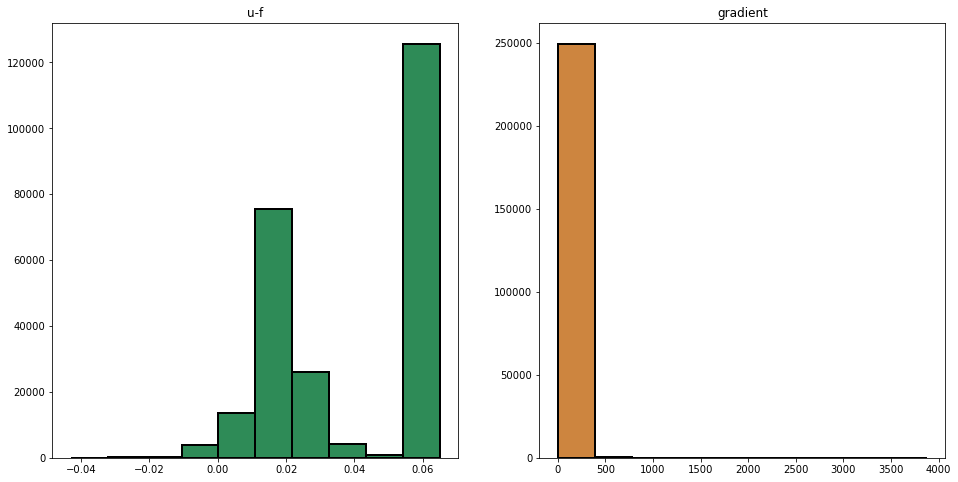

In [28]:
nfev = 100*(len(elm04.get_params())+1)
elm_solver(elm04, method='standard', max_nfev=nfev)

In [50]:
elm04.prune()
xc, yc, c, sig = elm04.get_params_mapped()
w = elm04.get_w()
mu = np.vstack([xc, yc]).T

In [51]:
components_dict04, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 139 and 189 with 5.916877530378511e-09 KL dist and 6.781715124434579e-14 ISD dist
Merged components 24 and 102 with 7.873401090006137e-09 KL dist and 8.458922268084093e-14 ISD dist
Merged components 155 and 205 with 8.252212182579925e-09 KL dist and 7.790812494849644e-14 ISD dist
Merged components 192 and 217 with 1.230390011112356e-08 KL dist and 8.88602367796596e-14 ISD dist
Merged components 7 and 178 with 1.4849786601478938e-08 KL dist and 1.225017836925748e-12 ISD dist
Merged components 86 and 215 with 1.628673359436154e-08 KL dist and 3.5817929206444763e-12 ISD dist
Merged components 64 and 112 with 1.7912813941767163e-08 KL dist and 1.3660317532387524e-11 ISD dist
Merged components 82 and 133 with 1.8125284172612182e-08 KL dist and 9.528047877646076e-12 ISD dist
Merged components 73 and 148 with 2.1024607841957448e-08 KL dist and 4.666601075882697e-12 ISD dist
Merged components 150 and 209 with 2.2293131507537125e-08 KL dist and 7.698541786311623e-12 ISD dist
M

Merged components 12 and 60 with 8.766698917967901e-07 KL dist and 1.7143164723762104e-09 ISD dist
Merged components 68 and 134 with 8.979802311258069e-07 KL dist and 1.040604057119563e-09 ISD dist
Merged components 53 and 72 with 9.100241286177674e-07 KL dist and 1.65550413358628e-11 ISD dist
Merged components 100 and 104 with 9.232038228754954e-07 KL dist and 5.708520453466398e-10 ISD dist
Merged components 68 and 115 with 9.58178484488975e-07 KL dist and 4.24431435748858e-10 ISD dist
Merged components 37 and 85 with 9.843305585027464e-07 KL dist and 1.0687050503599036e-10 ISD dist
Merged components 89 and 97 with 1.046191331854704e-06 KL dist and 9.986095537691825e-10 ISD dist
Merged components 22 and 117 with 1.1051286027569773e-06 KL dist and 1.7259941654404534e-09 ISD dist
Merged components 79 and 112 with 1.1093145835785123e-06 KL dist and 4.9246248839580635e-11 ISD dist
Merged components 5 and 81 with 1.1989630623419895e-06 KL dist and 1.2667561909924218e-08 ISD dist
Merged com

Merged components 12 and 28 with 1.8960832039888154e-05 KL dist and 6.476476245705016e-08 ISD dist
Merged components 11 and 23 with 1.900097203921526e-05 KL dist and 1.7993695716924426e-07 ISD dist
Merged components 1 and 11 with 1.9337480203447937e-05 KL dist and 9.296329284746074e-08 ISD dist
Merged components 6 and 8 with 2.0321437706856583e-05 KL dist and 9.82759726742457e-08 ISD dist
Merged components 3 and 4 with 2.493237845198771e-05 KL dist and 2.1452017565293306e-07 ISD dist
Merged components 11 and 23 with 2.597758450647492e-05 KL dist and 2.697651919166008e-08 ISD dist
Merged components 10 and 16 with 2.631016931188909e-05 KL dist and 2.7812792423631076e-07 ISD dist
Merged components 5 and 6 with 2.7402166672968443e-05 KL dist and 1.9267728297377178e-07 ISD dist
Merged components 6 and 14 with 2.8064968734060737e-05 KL dist and 1.0179439729389571e-07 ISD dist
Merged components 3 and 27 with 3.1883110305099276e-05 KL dist and 2.291075225387642e-08 ISD dist
Merged components 3

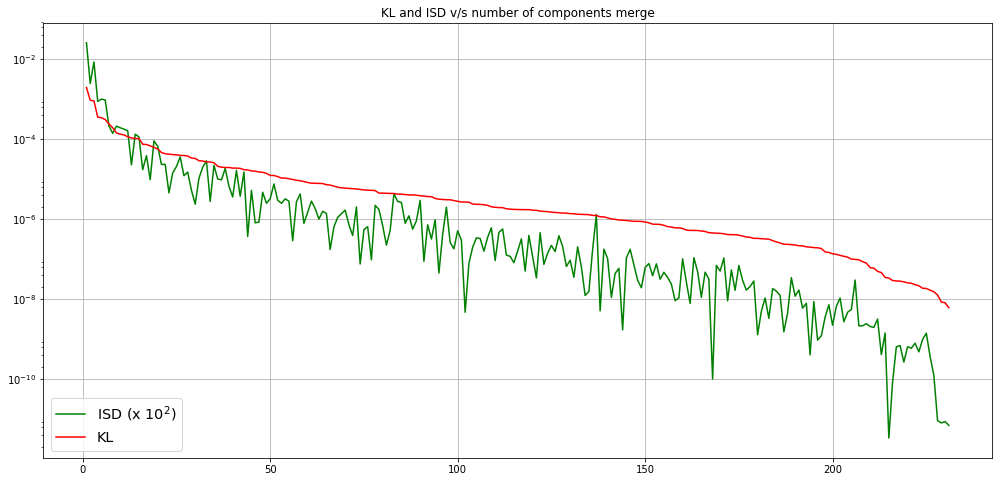

In [52]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [53]:
interact(components_plot, elm=fixed(elm04), data=fixed(data), components_dict=fixed(components_dict04), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>

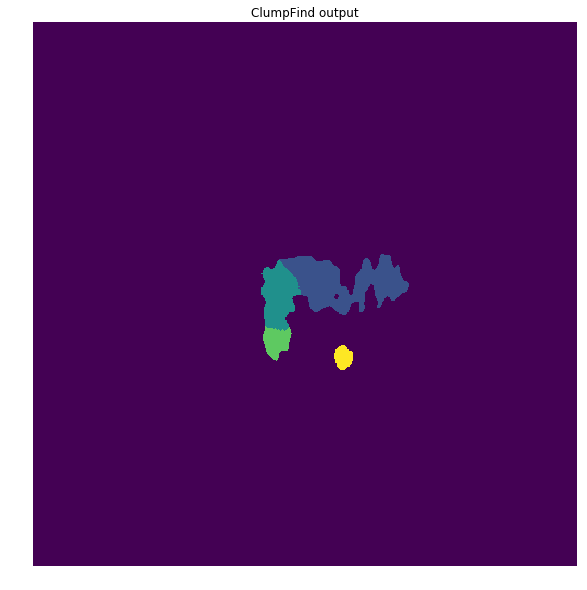

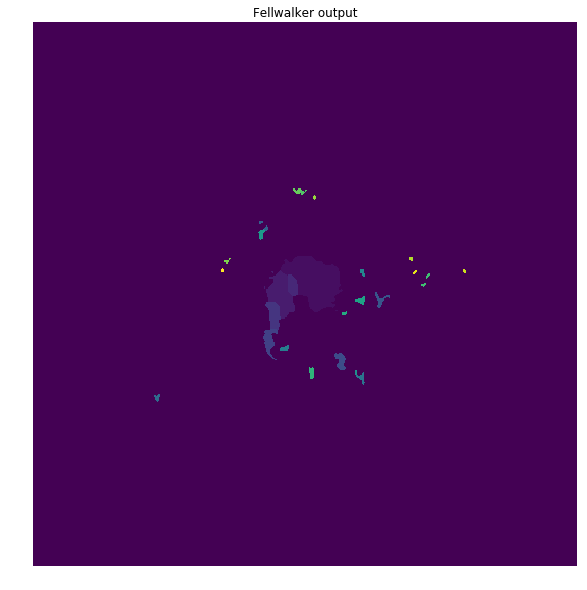

In [94]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw)
plt.axis('off')
plt.show()

***
***
# TWHydra_CO3_2

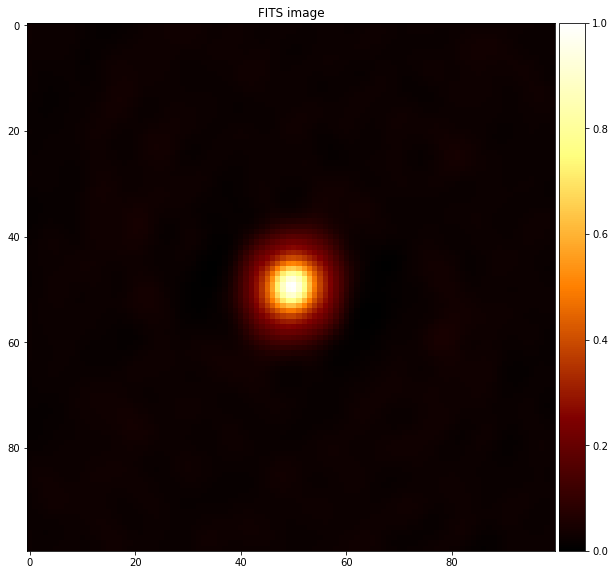

In [27]:
fits_path = '../data/images/TWHydra_CO3_2line.image.mom0.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [28]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

<function graph.thresholded_image_plot>

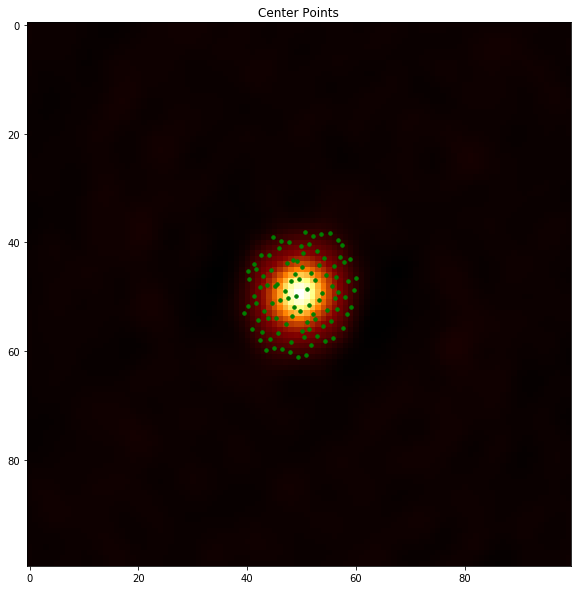

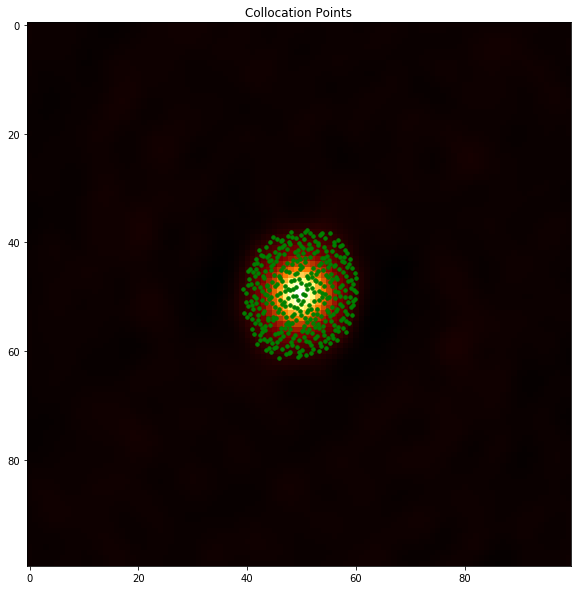

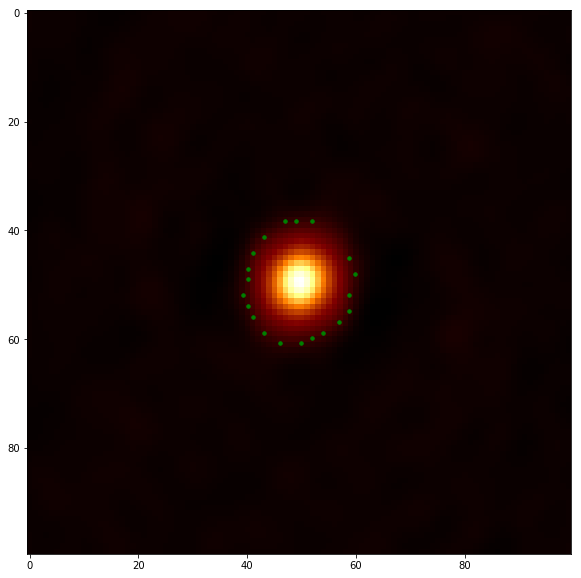

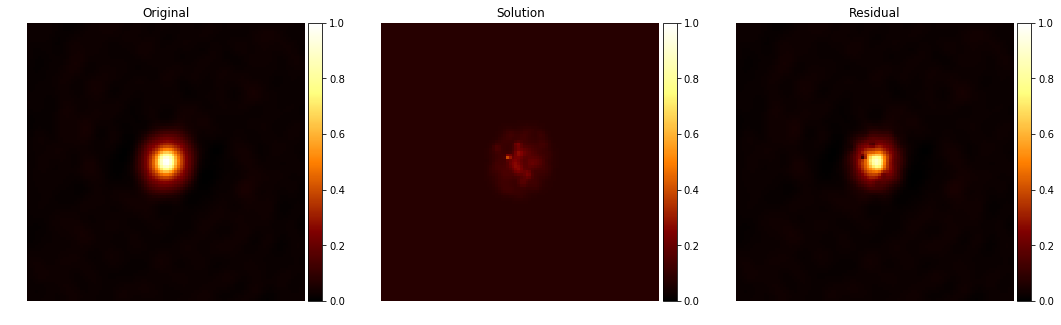

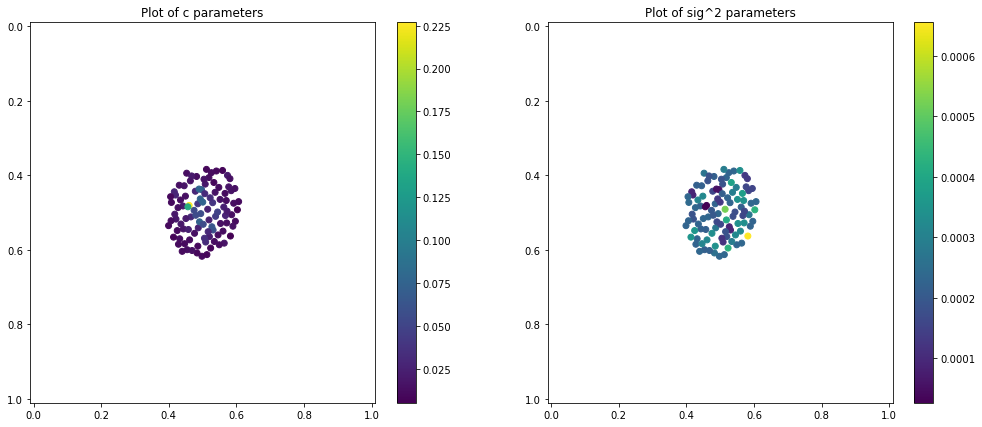

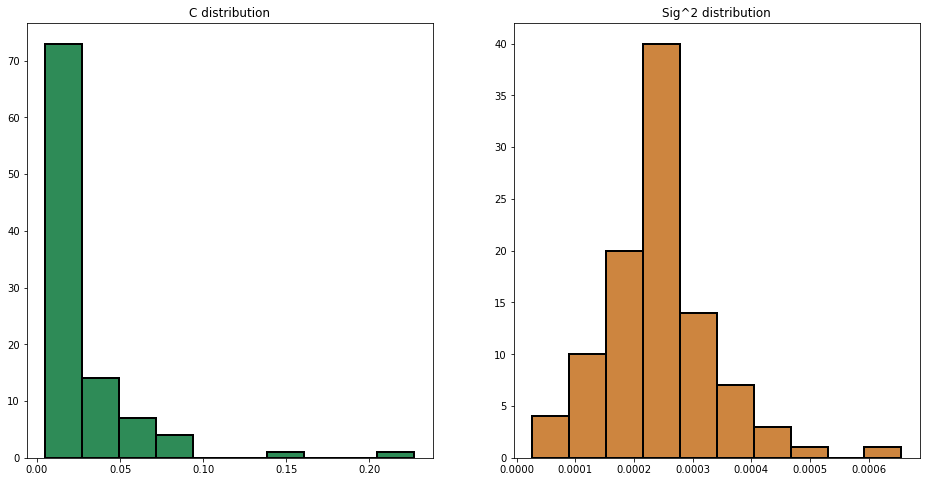

In [33]:
Nc = 100
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
    boundary_points = boundary_points_generation(data, base_level, Nb)   

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm05 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 40100.
nfev: 40110

Residual stats:
Residual RMS: 0.004725811173456893
Residual Variance: 2.2284575475572494e-05
Flux Lost: 0.004565006250243686
Flux Addition: 0.003777220913784295
psi1(u-f): 0.002254583211596921
Exceeded Pixels: 227
Sharpness: 27.078598644387856
psi2(grad u): 1.8731358034205645
Total elapsed time: 38.4458212852478 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.022156054235557228
Mean min distance between collocation and center points: 0.00876485431517697

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.13208694774736435
Max min distance in the (standarized) parameters space: 0.24839391176595782


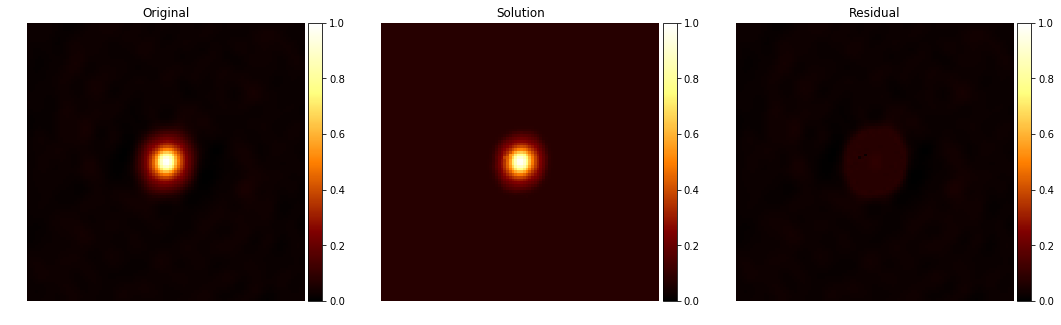

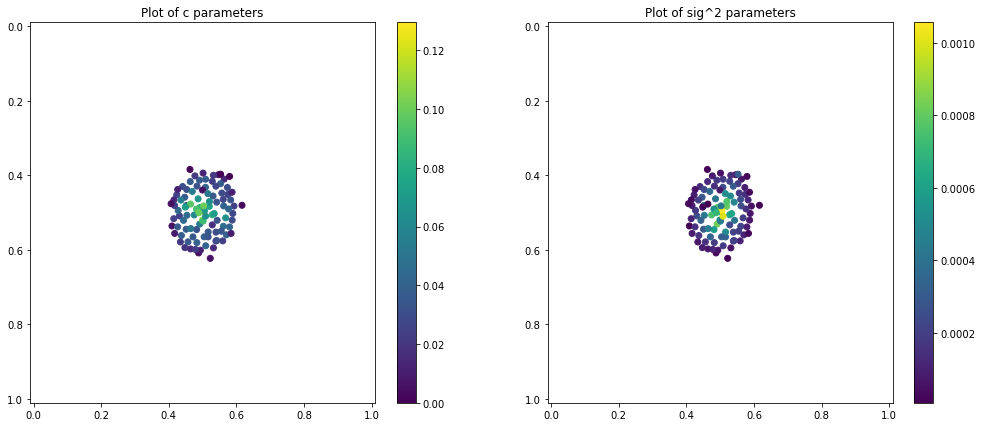

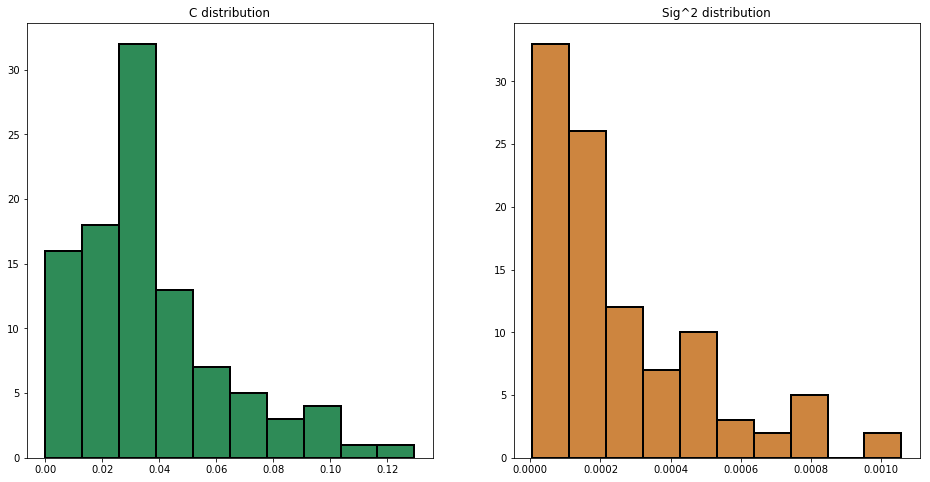

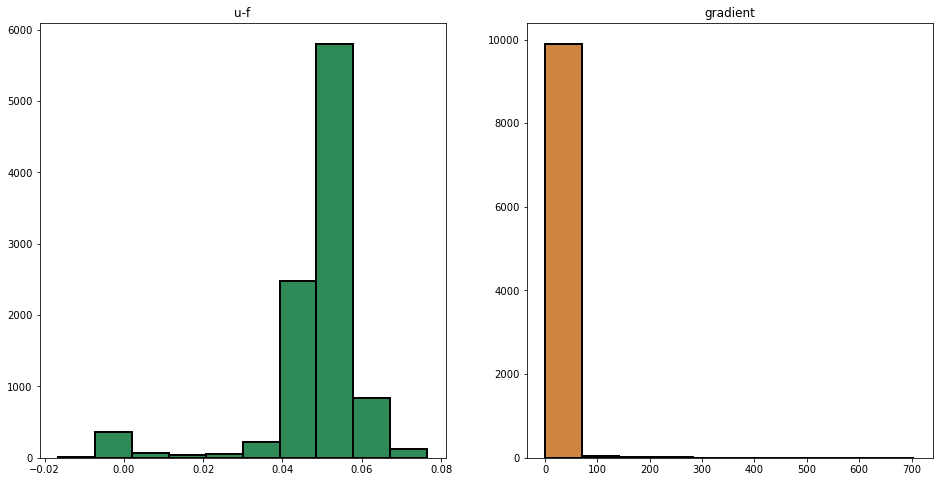

In [34]:
nfev = 100*(len(elm05.get_params())+1)
elm_solver(elm05, method='standard', max_nfev=nfev)

In [35]:
elm05.prune()
xc, yc, c, sig = elm05.get_params_mapped()
w = elm05.get_w()
mu = np.vstack([xc, yc]).T

In [36]:
components_dict05, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 49 and 86 with 2.803053068836333e-07 KL dist and 6.2760846934501076e-15 ISD dist
Merged components 6 and 44 with 5.50988545166108e-07 KL dist and 2.1429400830896197e-10 ISD dist
Merged components 8 and 80 with 6.416906366159671e-07 KL dist and 1.9751347470332955e-10 ISD dist
Merged components 7 and 65 with 8.517700516996068e-07 KL dist and 7.089505886896062e-10 ISD dist
Merged components 53 and 85 with 9.960299834624972e-07 KL dist and 4.030618605988317e-10 ISD dist
Merged components 11 and 45 with 1.2297732606472294e-06 KL dist and 1.1092653485916005e-09 ISD dist
Merged components 12 and 22 with 2.042738661395276e-06 KL dist and 1.971717449550182e-09 ISD dist
Merged components 21 and 70 with 2.295588563197849e-06 KL dist and 1.5862760016812483e-09 ISD dist
Merged components 30 and 38 with 2.8272322632883025e-06 KL dist and 3.144953000476384e-09 ISD dist
Merged components 6 and 20 with 3.1484409052806125e-06 KL dist and 5.554410654499714e-09 ISD dist
Merged components

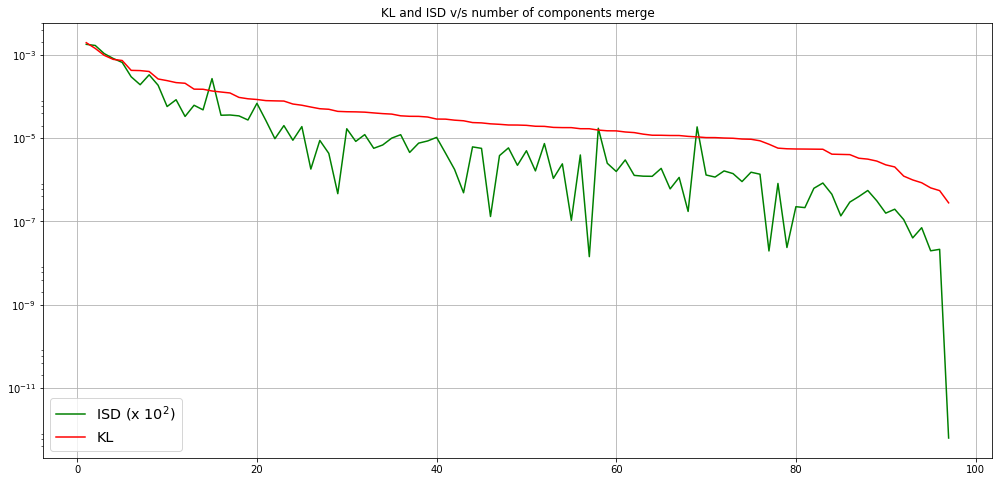

In [37]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [39]:
interact(components_plot, elm=fixed(elm05), data=fixed(data), components_dict=fixed(components_dict05), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

<function graph.components_plot>